In [241]:
# Import libraries
import pandas as pd
import numpy as np
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

from matplotlib import pyplot
from matplotlib.pyplot import figure

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA
from pca import pca

from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 
from bertopic import BERTopic
from ipywidgets import interact, interact_manual
import unittest


import warnings
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

### Load In Data & Perform Basic Cleanup

In [103]:
f = open('data/Dairy_aggregate.xlsx', 'rb').read()
dairy_ag_df = pd.read_excel(f)

In [104]:
dairy_ag_df.dtypes

Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                    object
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)     object
(SE710) Processing of crops (€/farm)                             object
(SE730) Other OGA output (€/farm)                                object
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [105]:
def replace_missing_str(df):
    for column in df.columns.tolist():
        df[column] = df[column].apply(lambda value: value.replace('-', '---') if value == '-' else value)
        df[column] = df[column].replace('---', np.nan)
        try:
            if df[column].dtype == 'object':
                df[column] = df[column].astype(float)
        except Exception as e:
            print(e)

replace_missing_str(dairy_ag_df)
dairy_ag_df.dtypes

dairy_ag_df['Year'] = dairy_ag_df['Year'].astype(int)

could not convert string to float: 'EU-28'
could not convert string to float: '(5) Milk'
could not convert string to float: '(45) Specialist milk'
could not convert string to float: '10000 - <20000'


Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                   float64
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)    float64
(SE710) Processing of crops (€/farm)                            float64
(SE730) Other OGA output (€/farm)                               float64
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [106]:
dairy_ag_df.describe()

,Year,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)

In [107]:
dairy_ag_df.head(5)

,Year,Member State,8 Types of Farming,14 Types of Farming,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed as

In [108]:
# Doing it this way so I can add more columns later and this will skip the columns that were already dropped.

dairy_ag_df = dairy_ag_df[[
        'Year',
        'Member State',
        "(SE005) Economic size (€'000)",
        '(SE010) Total labour input (AWU)',
        '(SE011) Labour input (hrs)',
        '(SE015) Unpaid labour input (AWU)',
        '(SE016) Unpaid labour input (hrs)',
        '(SE020) Paid labour input (AWU)',
        '(SE021) Paid labour Input (hrs)',
        '(SE025) Total Utilised Agricultural Area (ha)',
        '(SE026) Arable land (ha)',
        '(SE027) Permanent crops (ha)',
        '(SE028) Permanent grassland (ha)',
        '(SE030) Rented UAA (ha)',
        '(SE073) Set aside (ha)',
        '(SE074) Total agricultural area out of production (ha)',
        '(SE080) Total livestock units (LU)',
        '(SE085) Dairy cows (LU)',
        '(SE086) Cattle dairy cows (LU)',
        '(SE087) Buffalo dairy cows (LU)',
        '(SE120) Stocking density (LU/ha)',
        '(SE125) Milk yield (kg/cow)',
        '(SE126) Milk yield cattle dairy cows (kg/cow)',
        '(SE127) Milk yield buffalo dairy cows (kg/cow)',
        '(SE131) Total output (€/farm)',
        '(SE132) Total output / Total input (ratio)',
        '(SE206) Total output livestock & livestock products (€/farm)',
        '(SE207) Total livestock output (€/LU)',
        '(SE211) Change in value of livestock (€)',
        "(SE216) Cows' milk & milk products (€/farm)",
        '(SE022) Share of OGA work /AWU (%)',
        '(SE256) Other output (€/farm)',
        '(SE260) Farmhouse consumption (€)',
        '(SE265) Farm use (€)',
        '(SE270) Total Inputs (€)',
        '(SE275) Total intermediate consumption (€)',
        '(SE281) Total specific costs (€)',
        '(SE295) Fertilisers (€)',
        '(SE309) Specific livestock costs (€/LU)',
        '(SE310) Feed for grazing livestock (€)',
        '(SE315) Feed for grazing livestock home-grown (€)',
        '(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm)',
        '(SE336) Total farming overheads (€)',
        '(SE340) Machinery & building current costs (€)',
        '(SE345) Energy (€)',
        '(SE350) Contract work (€)',
        '(SE356) Other direct inputs (€)',
        '(SE360) Depreciation (€)',
        '(SE365) Total external factors (€)',
        '(SE370) Wages paid (€)',
        '(SE375) Rent paid (€)',
        '(SE380) Interest paid (€)',
        '(SE381) Balance of interest paid and received (€)',
        '(SE390) Taxes (€)',
        '(SE395) VAT balance excluding on investments (€)',
        '(SE405) Balance subsidies & taxes on investments (€)',
        '(SE406) Subsidies on investments (€)',
        '(SE407) Payments to dairy outgoers (€)',
        '(SE408) VAT balance on investments (€)',
        '(SE409) Subsidies on agricultural investments (€)',
        '(SE410) Gross Farm Income (€)',
        '(SE415) Farm Net Value Added (€)',
        '(SE420) Farm Net Income (€)',
        '(SE425) Farm Net Value Added (€/AWU)',
        '(SE430) Family Farm Income (€/FWU)',
        '(SE436) Total assets (€)',
        '(SE437) Total assets, opening valuation (€)',
        '(SE441) Total fixed assets (€)',
        '(SE446) Land, permanent crops & quotas (€)',
        '(SE450) Buildings (€)',
        '(SE455) Machinery and equipment (€)',
        '(SE460) Breeding livestock (€)',
        '(SE465) Total current assets (€)',
        '(SE470) Non-breeding livestock (€)',
        '(SE475) Stock of agricultural products (€)',
        '(SE476) Inventories (€)',
        '(SE480) Other circulating capital (€)',
        '(SE485) Total liabilities (€)',
        '(SE490) Long & medium-term loans (€)',
        '(SE495) Short-term loans (€)',
        '(SE501) Net worth (€)',
        '(SE506) Change in net worth (€)',
        '(SE510) Average farm capital (€)',
        '(SE516) Gross Investment on fixed assets (€)',
        '(SE521) Net Investment on fixed assets (€)',
        '(SE526) Cash Flow 1 (€)',
        '(SE530) Cash Flow 2 (€)',
        '(SE532) Cash flow / farm total capital (€)',
        '(SE600) Balance current subsidies & taxes (€)',
        '(SE605) Total subsidies - excluding on investments (€)',
        '(SE606) Total direct payments (€)',
        '(SE611) Compensatory payments/area payments (€)',
        '(SE612) Set aside premiums (€)',
        '(SE615) Total subsidies on livestock (€)',
        '(SE616) Subsidies dairying (€)',
        '(SE618) Subsidies sheep & goats (€)',
        '(SE621) Environmental subsidies (€)',
        '(SE622) LFA subsidies (€)',
        '(SE623) Other rural development payments (€)',
        '(SE624) Total support for rural development (€)',
        '(SE625) Subsidies on intermediate consumption (€)',
        '(SE626) Subsidies on external factors (€)',
        '(SE630) Decoupled payments (€)',
        '(SE631) Single Farm payment (€)',
        '(SE632) Single Area payment (€)',
        '(SE640) Additional aid (€)',
        '(SE650) Support_Art68 (€)',
        '(SE699) Other subsidies (€)',
        '(SE700) Total OGA output (€/farm)',
        '(SE720) Contractual work services (€)',
        '(SE725) Agritourism (€)',
        '(SE750) Total specific costs for OGA (€)',
        '(SE447) Agricultural land (€/farm)',
        '(SE462) Intangible assets (€/farm)',
        '(SE332) Veterinary expenses (€/farm)',
        '(SE765) Milk processing specific cost (€/farm)',
        "(SE766) Cows' milk processing specific cost (€/farm)",
        "(SE705) Processing of animals and animals' products (€/farm)",
        '(SE730) Other OGA output (€/farm)',
        '(SYS02) Farms represented (nb)',
            ]]

In [109]:
dairy_ag_df = dairy_ag_df[dairy_ag_df['Year'] < 2022] # Dropping because a lot of countries still have not submitted the data for 2022 onwards
dairy_ag_df.tail()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

In [110]:
len(dairy_ag_df.columns.tolist())

120

In [111]:
# Standardise member state names across different datasets
dairy_ag_df = dairy_ag_df[(dairy_ag_df['Member State'] != 'EU27_2020') & (dairy_ag_df['Member State'] != 'EU-28') & (dairy_ag_df['Member State'] != '(UK) United Kingdom')]

# Clean up the member state names. The initial dataframe has ISO-2 country codes in the member state column appended to the country name. This impedes the ability to merge dataframes on the member state column. This code removes the ISO-2 country codes from the member state column.
dairy_ag_df['Member State'] = dairy_ag_df['Member State'].apply(lambda x: x[5:] if x[0].strip() == '(' else x)
dairy_ag_df.head()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

In [112]:
dairy_ag_df.shape

(471, 120)

In [113]:
dairy_ag_df[dairy_ag_df['Member State'] == '']['Year'].unique()
dairy_ag_df[dairy_ag_df['Member State'] == 'United Kingdom']['Year'].unique()
dairy_ag_df[(dairy_ag_df['Member State'] == 'Belgium')].Year.unique()

array([], dtype=int32)

array([], dtype=int32)

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [114]:
dairy_ag_df[(dairy_ag_df['Member State'] == 'Ireland') & (dairy_ag_df['Year'] == 2019)]

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

In [115]:
dairy_ag_df['Member State'].unique()
dairy_ag_df['Member State'].unique().size

dairy_ag_df['Year'].unique()
dairy_ag_df['Year'].unique().size

# dairy_ag_df['(SE005) Economic size (€\'000)'].unique()
# dairy_ag_df['(SE005) Economic size (€\'000)'].unique().size

array(['Belgium', 'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland',
       'Greece', 'Spain', 'France', 'Italy', 'Cyprus', 'Latvia',
       'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Slovenia', 'Slovakia', 'Finland',
       'Sweden', 'Bulgaria', 'Romania', 'Croatia'], dtype=object)

27

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021])

18

In [116]:
dairy_ag_df.columns.tolist()

['Year',
 'Member State',
 "(SE005) Economic size (€'000)",
 '(SE010) Total labour input (AWU)',
 '(SE011) Labour input (hrs)',
 '(SE015) Unpaid labour input (AWU)',
 '(SE016) Unpaid labour input (hrs)',
 '(SE020) Paid labour input (AWU)',
 '(SE021) Paid labour Input (hrs)',
 '(SE025) Total Utilised Agricultural Area (ha)',
 '(SE026) Arable land (ha)',
 '(SE027) Permanent crops (ha)',
 '(SE028) Permanent grassland (ha)',
 '(SE030) Rented UAA (ha)',
 '(SE073) Set aside (ha)',
 '(SE074) Total agricultural area out of production (ha)',
 '(SE080) Total livestock units (LU)',
 '(SE085) Dairy cows (LU)',
 '(SE086) Cattle dairy cows (LU)',
 '(SE087) Buffalo dairy cows (LU)',
 '(SE120) Stocking density (LU/ha)',
 '(SE125) Milk yield (kg/cow)',
 '(SE126) Milk yield cattle dairy cows (kg/cow)',
 '(SE127) Milk yield buffalo dairy cows (kg/cow)',
 '(SE131) Total output (€/farm)',
 '(SE132) Total output / Total input (ratio)',
 '(SE206) Total output livestock & livestock products (€/farm)',
 '(SE20

In [117]:
dairy_ag_df['national_milk_production_tonnes'] = (dairy_ag_df['(SE085) Dairy cows (LU)'] * 
                                                  dairy_ag_df['(SE125) Milk yield (kg/cow)'] *
                                                  dairy_ag_df['(SYS02) Farms represented (nb)']) / 1000

### EDA & Basic Dashboard Components

#### Deriving new data columns for Dashboard Visualisation

In [118]:
dairy_ag_df['Total agricultural area / country (ha)'] = (dairy_ag_df['(SE025) Total Utilised Agricultural Area (ha)'] *
                                                         dairy_ag_df['(SYS02) Farms represented (nb)'])

In [119]:
dairy_ag_df['Total Dairy Grassland (ha)'] = (dairy_ag_df['(SE028) Permanent grassland (ha)'] *
                                                  dairy_ag_df['(SYS02) Farms represented (nb)'])

In [120]:
dairy_ag_df['% Dairy grassland / Total utilised agricultural area (ha)'] = ((dairy_ag_df['(SE028) Permanent grassland (ha)'] *
                                                  dairy_ag_df['(SYS02) Farms represented (nb)']) / (dairy_ag_df['(SE025) Total Utilised Agricultural Area (ha)'] *
                                                  dairy_ag_df['(SYS02) Farms represented (nb)'])*100)

In [121]:
dairy_ag_df['Agricultrual Land Use'] = ((dairy_ag_df['(SE028) Permanent grassland (ha)'] + dairy_ag_df['(SE026) Arable land (ha)'] + dairy_ag_df['(SE027) Permanent crops (ha)']) / (dairy_ag_df['(SE025) Total Utilised Agricultural Area (ha)'] *
                                                  dairy_ag_df['(SYS02) Farms represented (nb)'])*100)

In [122]:
# Step 1: Calculate the total milk production for each year
total_milk_production = dairy_ag_df[dairy_ag_df.Year < 2022].groupby('Year', group_keys=False)['national_milk_production_tonnes'].sum()
total_milk_production = total_milk_production.to_frame().reset_index()
total_milk_production.rename(columns={'national_milk_production_tonnes': 'total_EU_milk_production_tonnes'}, inplace=True)
total_milk_production.head()
total_milk_production.tail()

# Step 2: Calculate the proportion of total milk production for each country using the Totals obtained in step 1
temporary_df_with_totals = dairy_ag_df[['Year', 'Member State']].merge(total_milk_production, on='Year', how='left')
temporary_df_with_totals.head()

temporary_df_with_totals.shape
dairy_ag_df.shape

# Step 3: Calculate the proportion of total milk production for each country using the temporary DF from step 2
dairy_ag_df['percentage_of_total_EU_milk_production'] = (dairy_ag_df['national_milk_production_tonnes'] / 
                                                         dairy_ag_df[['Year', 'Member State']].merge(total_milk_production, on='Year', how='left')['total_EU_milk_production_tonnes'] * 100)

dairy_ag_df['percentage_of_total_EU_milk_production']

,Year,total_EU_milk_production_tonnes
0,2004,9.329922e+07
1,2005,9.559063e+07
2,2006,9.918730e+07
3,2007,9.885544e+07
4,2008,1.004051e+08


,Year,total_EU_milk_production_tonnes
13,2017,1.242325e+08
14,2018,1.231052e+08
15,2019,1.251648e+08
16,2020,1.301666e+08
17,2021,1.290870e+08


,Year,Member State,total_EU_milk_production_tonnes
0,2004,Belgium,9.329922e+07
1,2004,Czechia,9.329922e+07
2,2004,Denmark,9.329922e+07
3,2004,Germany,9.329922e+07
4,2004,Estonia,9.329922e+07


(471, 3)

(471, 125)

1       1.959193
2       0.580427
3       4.413746
4      21.663352
5       0.484960
         ...    
509          NaN
510          NaN
511          NaN
512          NaN
513          NaN
Name: percentage_of_total_EU_milk_production, Length: 471, dtype: float64

In [123]:
dairy_ag_df[(dairy_ag_df.Year == 2015) & (dairy_ag_df['Member State'] == 'Ireland')][['national_milk_production_tonnes', '(SE131) Total output (€/farm)']]

,national_milk_production_tonnes,(SE131) Total output (€/farm)
314,7.203449e+06,199613.0


**************************************** NOTES TO SELF ***********************************************

Edit Cow's milk and milk products to reflect total output per country by multiplying by number of farms represented. Can reproduce milk production exclusively by multiplying dairy cow (LU) number by milk yield per cow (divide by 1,000 to convert to tonne per cow) multiplied by farms represented.

Compare to production output from other dataset

Compare with (SE216) Cows' milk & milk products (€/farm) multiplied by farms represented. Will return value of milk produced. Could be used to indicate profit/price of milk in each country if divided by amount produced. 

Then create column showing share of European production for each country and assess trend / prediction

**************************************** NOTES TO SELF ***********************************************


<Figure size 960x480 with 0 Axes>

<Axes: xlabel='Year', ylabel="(SE216) Cows' milk & milk products (€/farm)">

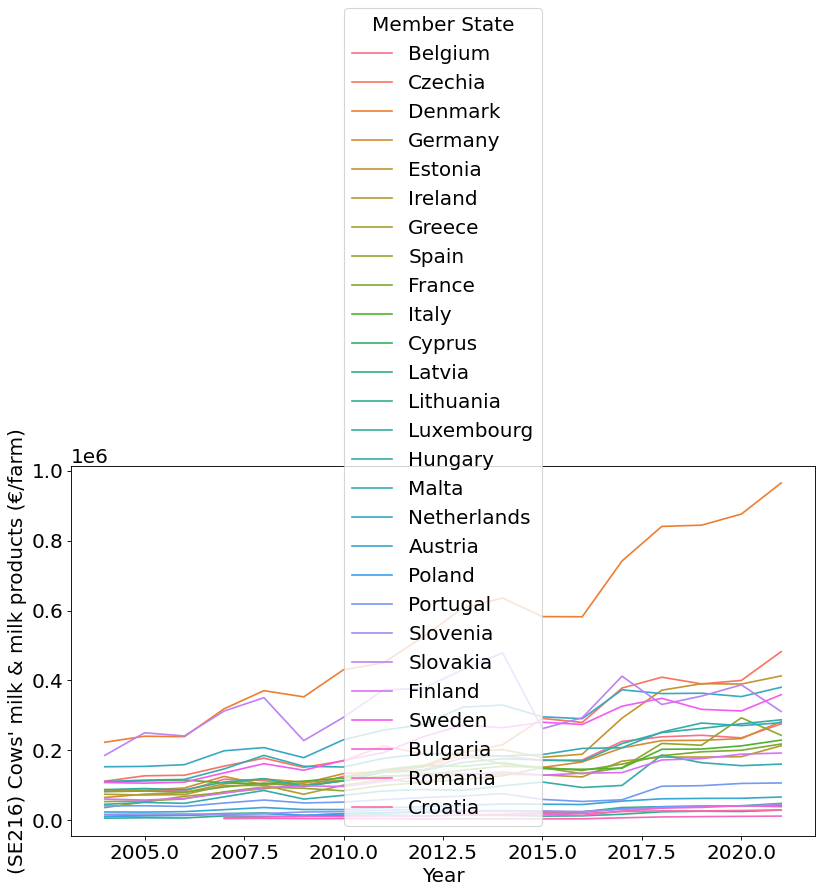

In [124]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x="Year", y="(SE216) Cows' milk & milk products (€/farm)", hue="Member State", data=dairy_ag_df)


In [125]:
# Create a Dash app to visualise Dairy output for european member states over time

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=dairy_ag_df.columns.tolist(),
            value="(SE085) Dairy cows (LU)",
        ),
    ],  style={'width': '30%', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Checklist(
                id="states",
                options=dairy_ag_df['Member State'].unique(),
                value=dairy_ag_df['Member State'].unique(),
            ),
        ], style={'width': '10%', 'float': 'left', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Graph(id="line-graph"),
    ],  style={'width': '90%', 'float': 'right', 'display': 'inline-block'}),
], style={"backgroundColor": "white"})


@app.callback(
    Output("line-graph", "figure"), 
    Input("metric", "value"),
    Input("states", "value"),
)
def update_line_chart(metric, states):
    data  = dairy_ag_df[dairy_ag_df['Member State'].isin(states)]
    fig = px.line(data, x="Year", y=metric, color='Member State', title=f"Dairy {metric}")
    return fig


app.run_server(debug=True, port=8063)

In [126]:
dairy_ag_df.head()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

#### Read In Country Codes for further Geo-mapping

In [127]:
# Read In Country Codes to be used for PLotly Choropleth, and merge them into our base dataframe - dairy_ag_df
country_codes = pd.read_csv('data/country_codes.tsv', sep='\t')
country_codes = country_codes[['Country', 'Alpha-3 code']]
country_codes.rename(columns={'Country': 'Member State'}, inplace=True)

dairy_ag_df = dairy_ag_df.merge(country_codes, on='Member State', how='left')
dairy_ag_df.rename(columns={'Alpha-3 code': 'country_code'}, inplace=True)

dairy_ag_df.head(2)

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

#### Correlation Matrix

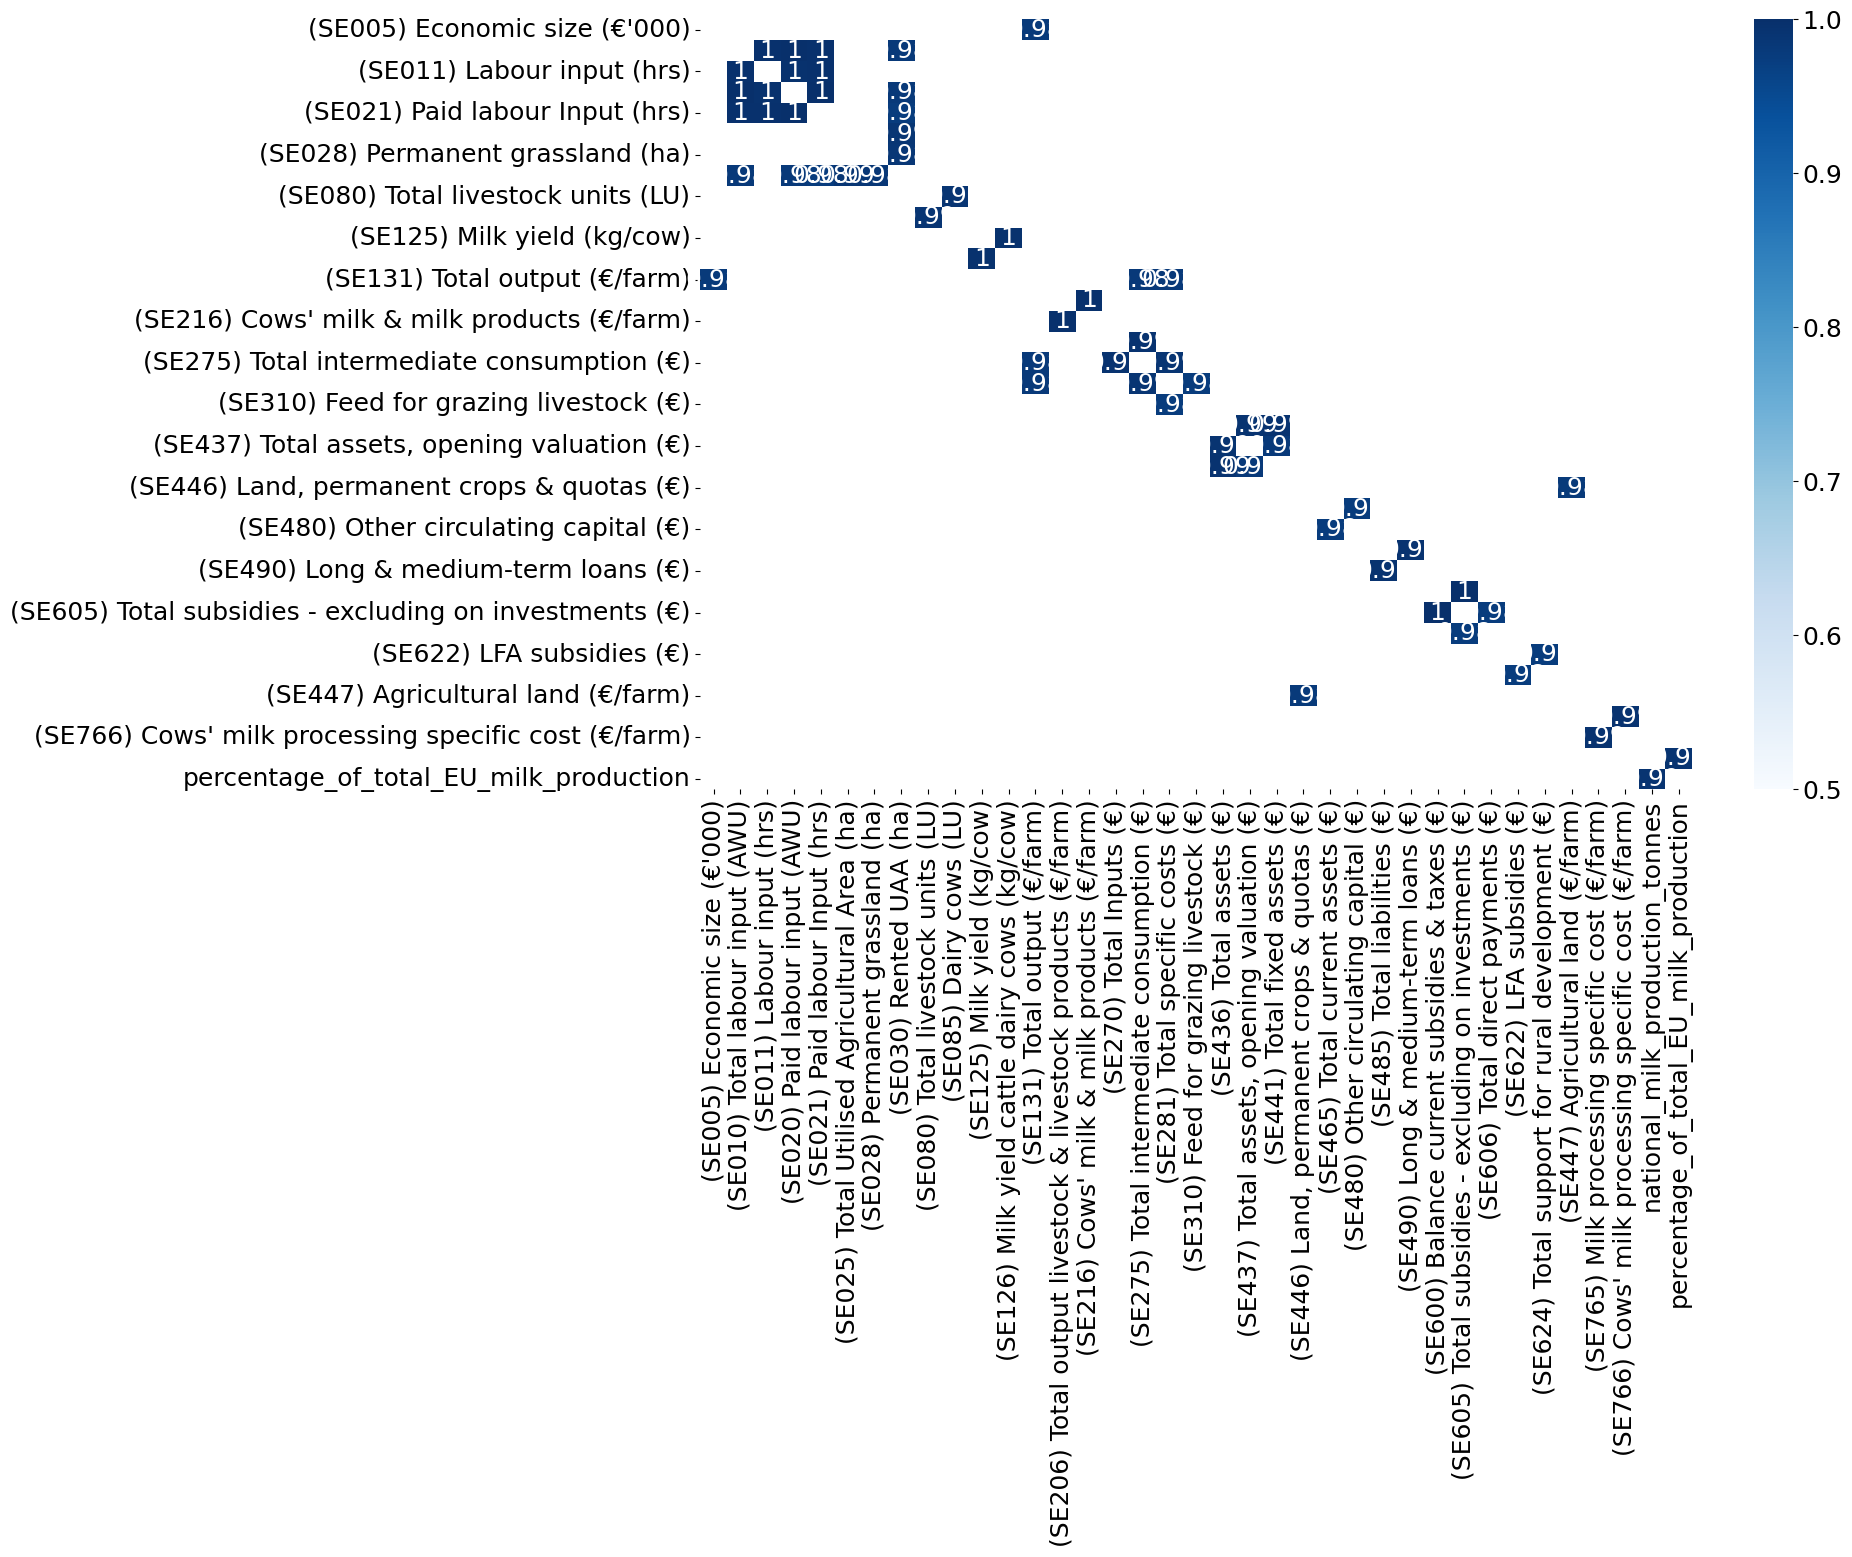

In [128]:
# Create a correlation matrix
corr_matrix = dairy_ag_df.select_dtypes(include=['float64', 'int64']).corr()

# Filter the matrix to only show correlations above 0.5
filtered_corr_matrix = corr_matrix[(corr_matrix >= 0.975) & (corr_matrix < 1)].dropna(how='all').dropna(axis=1, how='all')

# Plot the heatmap
fig, ax = pyplot.subplots(figsize=(16, 10))
sns.heatmap(filtered_corr_matrix, cmap="Blues", annot=True, vmin=0.5, vmax=1, ax=ax);

#### Data preparation: Imputing, Scaling, Encoding Y Labels

In [129]:
# Create an imputer object with a strategy of 'median'
imputer = SimpleImputer(strategy='median')

dairy_ag_df_imputed = dairy_ag_df.copy()

# Iterate over all NUMERIC columns in the dataframe
for column in dairy_ag_df.select_dtypes(include=['float64', 'int64']).columns:
    # Fit the imputer on the column
    dairy_ag_df_imputed[column]  = imputer.fit_transform(dairy_ag_df[[column]])


# Verify missing values
missing_values = dairy_ag_df_imputed.isna().sum()
# Print the number of missing values in each column
columns_with_missing_values = missing_values[missing_values > 0].index
print(columns_with_missing_values)

Index(['country_code'], dtype='object')


In [130]:
dairy_ag_df_imputed.head()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

In [131]:
Y_labels = dairy_ag_df_imputed['Member State']
X_features = dairy_ag_df_imputed.drop(columns=['Member State', 'country_code'])

In [132]:
# Create a StandardScaler object
scaler = MinMaxScaler()

# Fit the scaler and transform the features
X_features_scaled = scaler.fit_transform(X_features)

# The result is a numpy array, convert it back to a dataframe
X_features = pd.DataFrame(X_features_scaled, columns=X_features.columns)

In [133]:
X_features_scaled

array([[0.        , 0.12997984, 0.01642036, ..., 0.58358934, 0.01270921,
        0.08083209],
       [0.        , 0.19948162, 0.23836891, ..., 0.4960861 , 0.06884652,
        0.02297585],
       [0.        , 0.2937506 , 0.02627258, ..., 0.09529802, 0.01417711,
        0.1838309 ],
       ...,
       [1.        , 0.5155995 , 0.39490969, ..., 0.57252108, 0.23148819,
        0.07977773],
       [1.        , 0.20293751, 0.03338807, ..., 0.03769341, 0.01571773,
        0.07977773],
       [1.        , 0.50599981, 0.04926108, ..., 0.16169776, 0.02689502,
        0.07977773]])

In [134]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder and transform the labels
Y_labels_encoded = le.fit_transform(Y_labels)

# The result is a numpy array, convert it back to a pandas Series
Y_labels = pd.Series(Y_labels_encoded, name=Y_labels.name)

In [135]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!
# THIS IS WHERE THE BELOW IS COMING FROM

# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# https://erdogant.github.io/pca/pages/html/Examples.html

# Dataset 2 PCA/Clustering

### PCA

#### In order to determin the number of principal components....

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [125] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [125] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[14]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
       PC feature   loading  type
0     PC1      72  0.168948  best
1     PC2      63 -0.235118  best
2     PC3     121  0.394750  best
3     PC4       1  0.406609  best
4     PC5     123  0.477412  best
..    ...     ...       ...   ...
125   PC8     118  0.177473  weak
126 

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 14 Principal Components explain [91.29%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

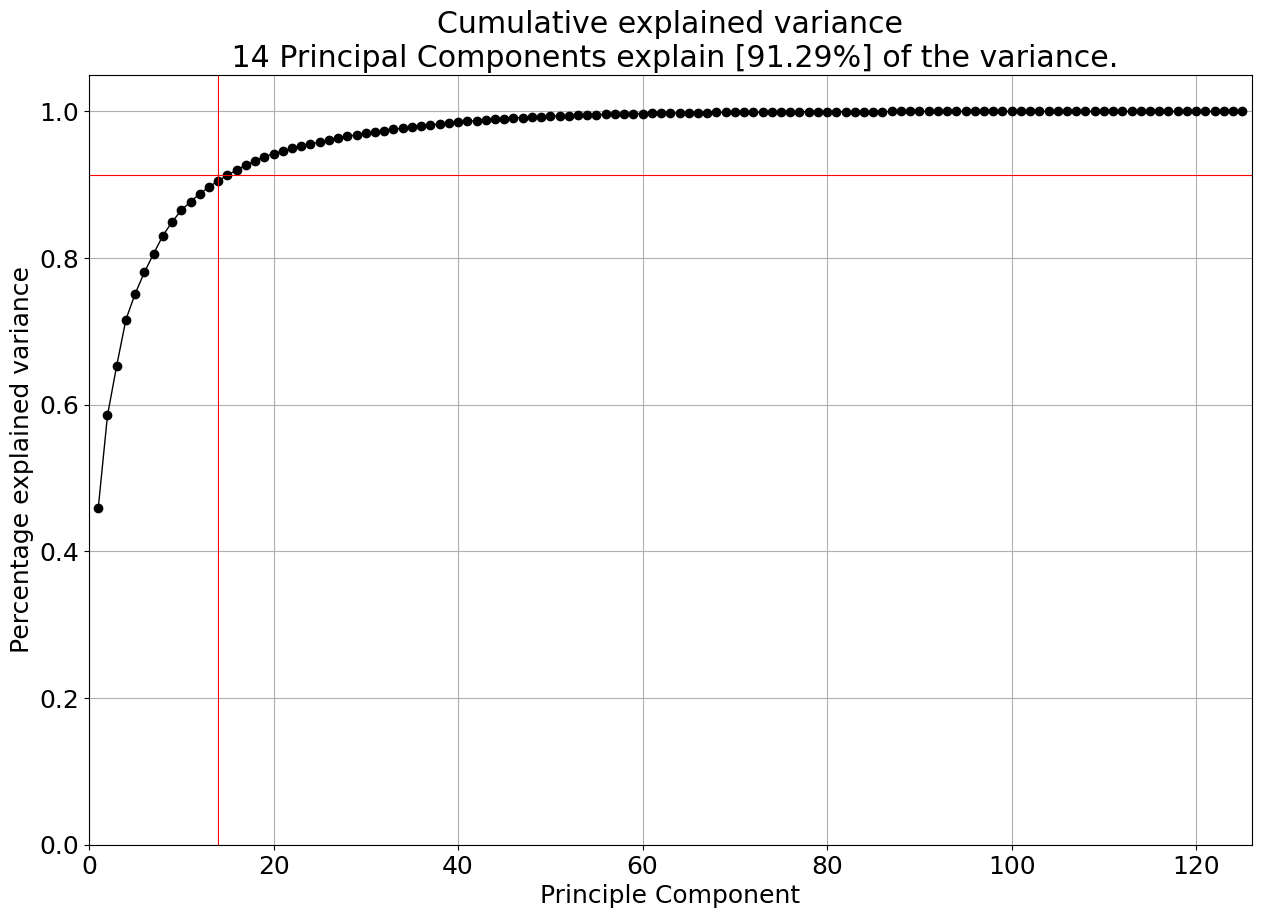

In [136]:
VARIANCE_THRESHOLD = 0.90

# Initialize
pca_model = pca(n_components=VARIANCE_THRESHOLD)
# Fit transform
pca_output = pca_model.fit_transform(X_features_scaled)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(pca_output['topfeat'])
pca_model.plot()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


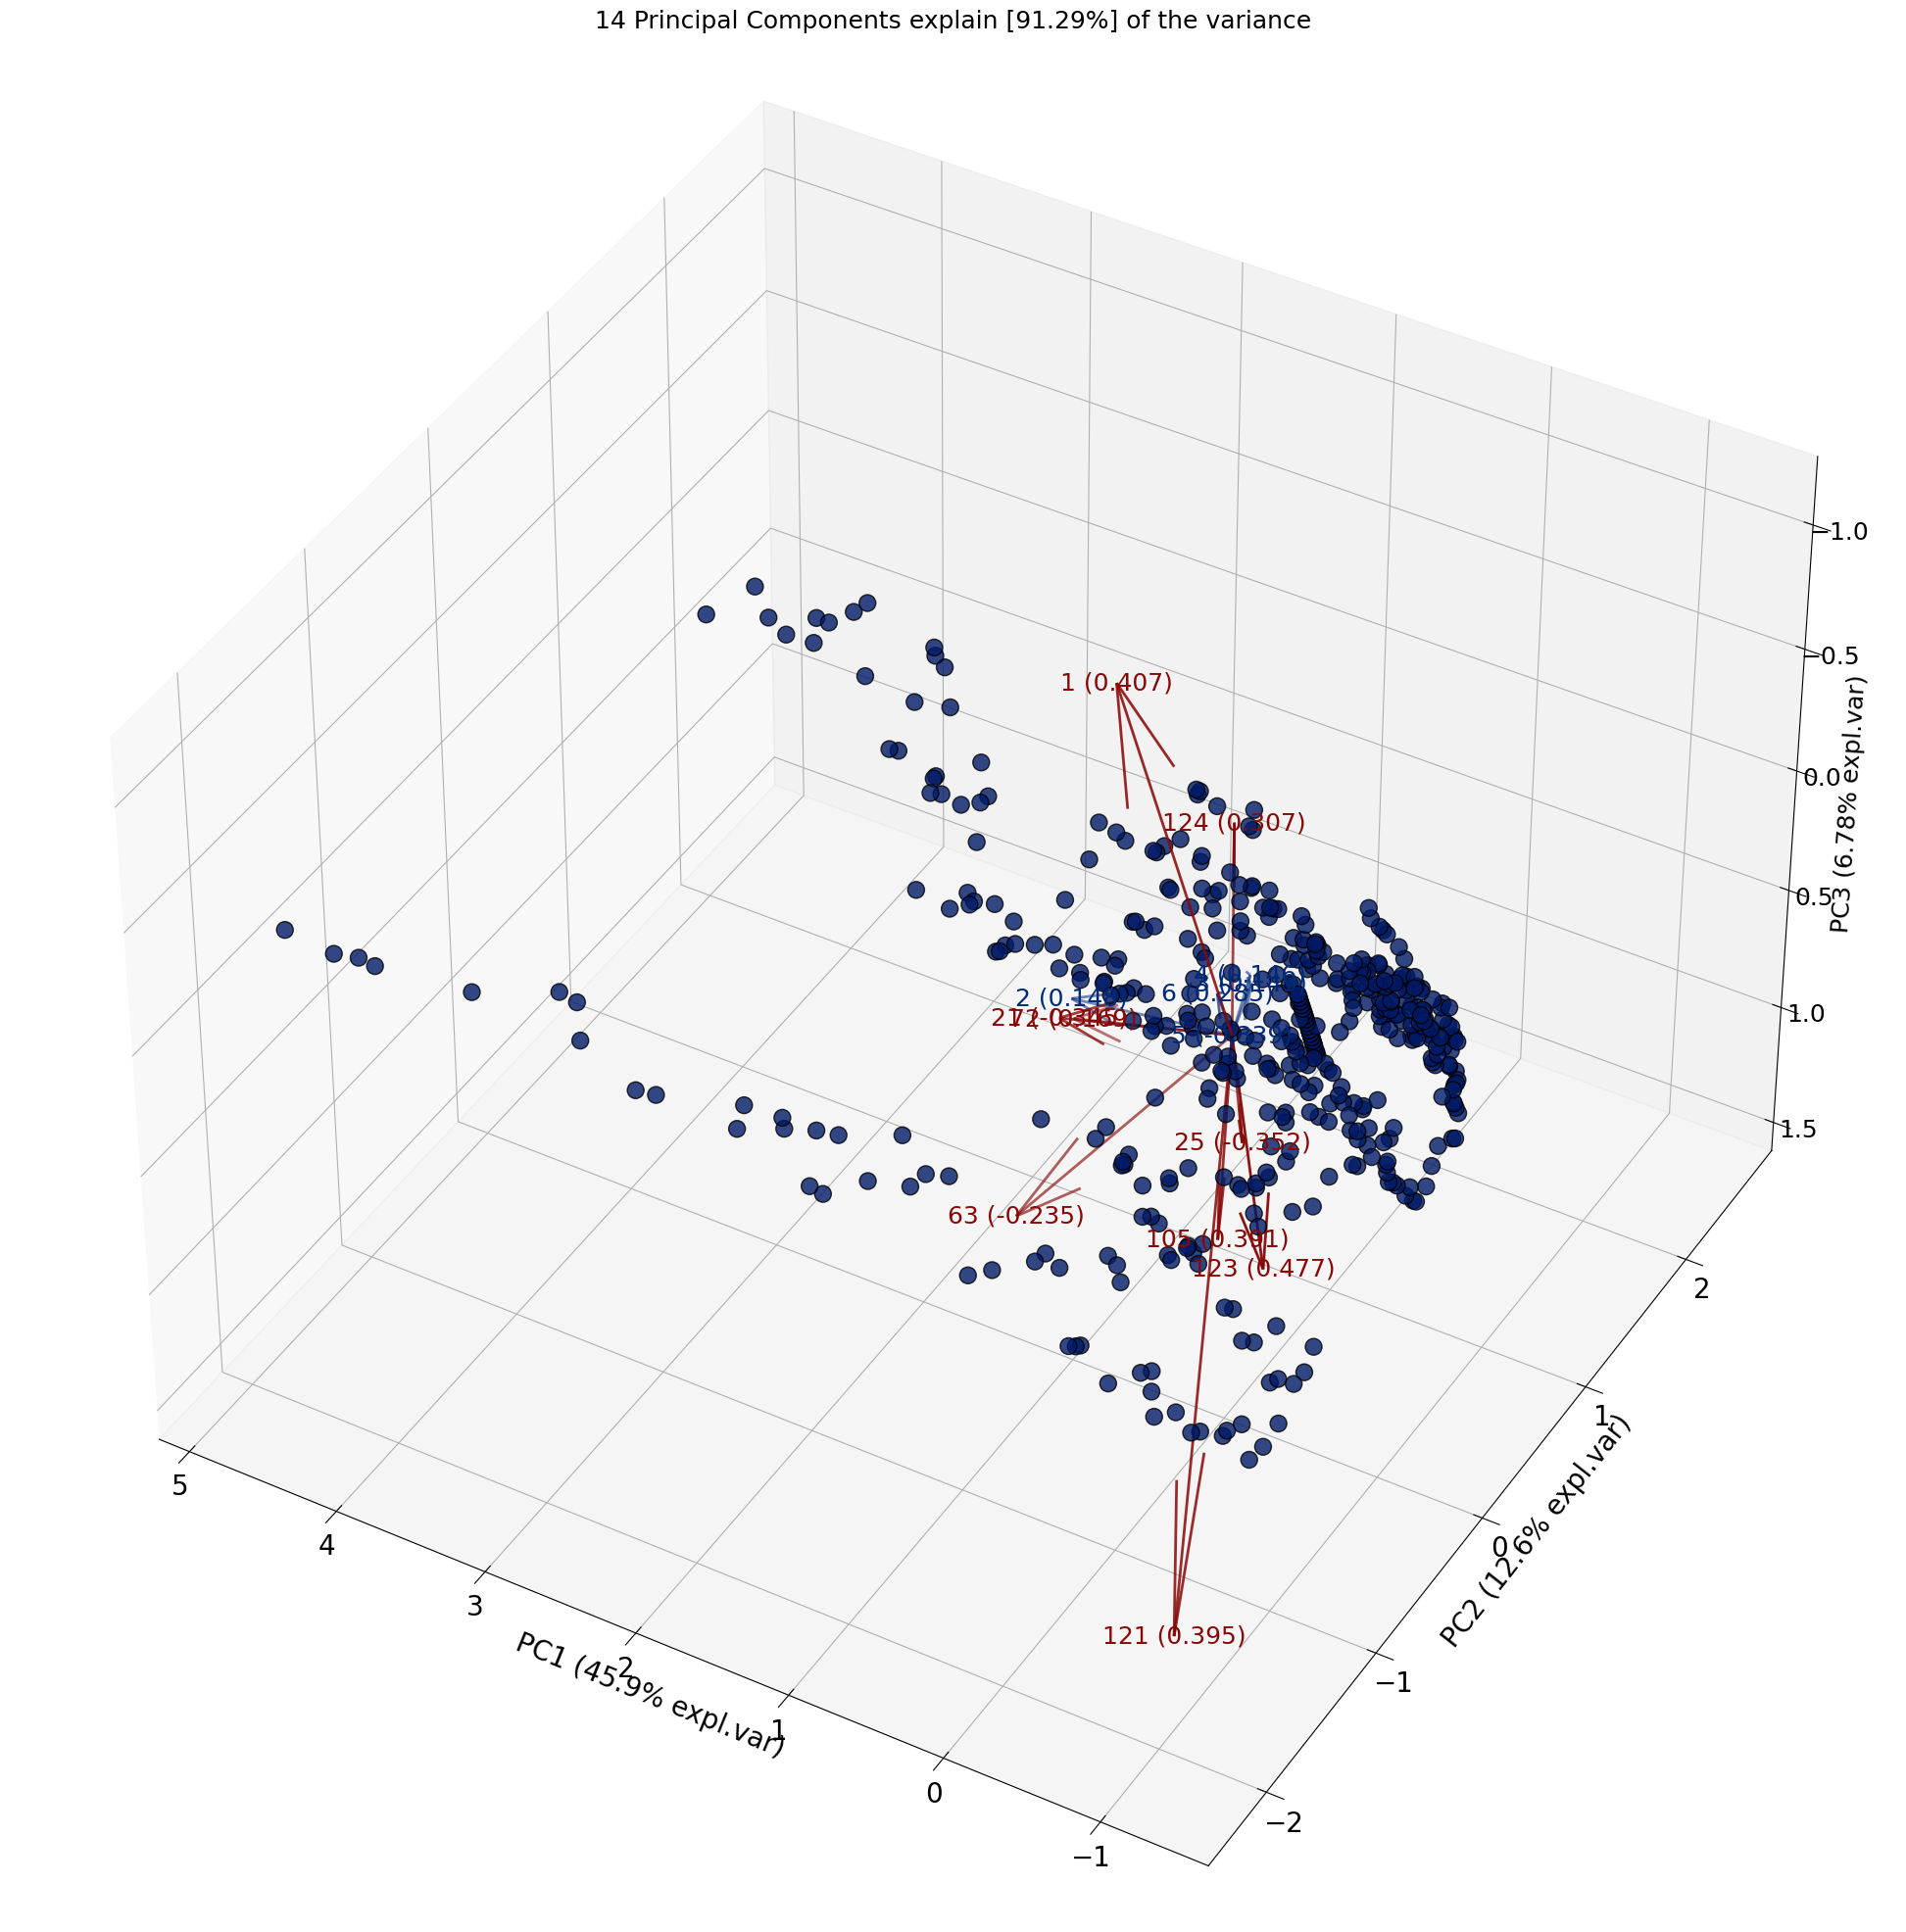

In [137]:
#ax = pca_model.biplot(n_feat=12 , legend=True)

ax = pca_model.biplot3d(n_feat=14, legend=False)


## K-Means Clustering

#### Using Skicit Learn libraries for feature seelction and subsequent k-means clustering

In [138]:
  
# Importing PCA 
NUM_COMPONENTS_TO_KEEP = 14

pca_scikit_model = PCA(n_components = NUM_COMPONENTS_TO_KEEP)
pca_scikit_model.fit(X_features_scaled)

X_features_pca = pca_scikit_model.transform(X_features_scaled)

PCA(n_components=14)

In [139]:
X_features_scaled.shape # initial dataframe with ALL features
X_features_pca.shape # PCA selected 14 of them that account for the most variance (Threshhold adjusted in  the first run of non-scikitlearn PCA)

(471, 125)

(471, 14)

In [140]:
pca_scikit_model.components_

array([[ 0.07002691,  0.1480128 ,  0.08089912, ..., -0.02014961,
         0.02727214, -0.00536875],
       [-0.09174979, -0.04798142,  0.14900331, ...,  0.03095799,
         0.03650686, -0.15239391],
       [-0.27911151, -0.01672676,  0.05998142, ...,  0.18610449,
        -0.12752529,  0.3436178 ],
       ...,
       [ 0.3047815 , -0.06285201, -0.03278222, ..., -0.15170457,
         0.04935989,  0.00263511],
       [-0.16941954, -0.02143195,  0.05236802, ..., -0.36227556,
        -0.01663213,  0.04675784],
       [ 0.11260412, -0.00363616,  0.05156795, ..., -0.12717445,
         0.13152687, -0.00589535]])

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'First Principal Component')

Text(0, 0.5, 'Second Principal Component')

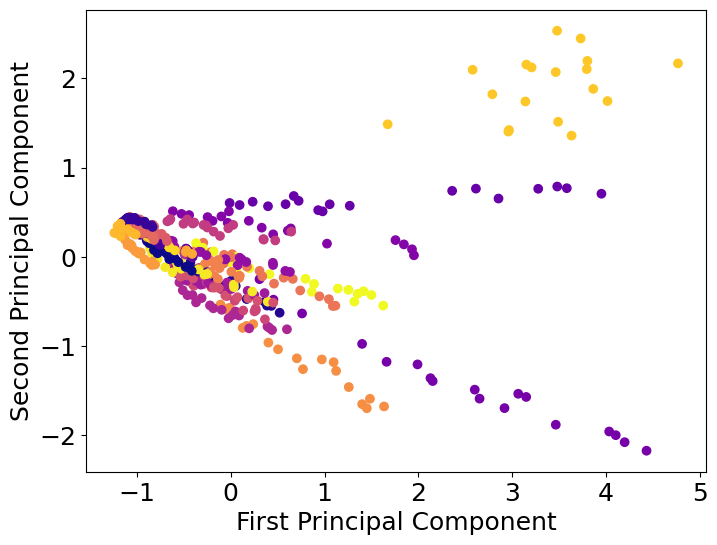

In [141]:
# giving a larger plot
plt.figure(figsize =(8, 6))
  
plt.scatter(X_features_pca[:, 0], X_features_pca[:, 1], c = Y_labels, cmap ='plasma')
  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [142]:
pca_scikit_model.components_, pca_scikit_model.explained_variance_ratio_

(array([[ 0.07002691,  0.1480128 ,  0.08089912, ..., -0.02014961,
          0.02727214, -0.00536875],
        [-0.09174979, -0.04798142,  0.14900331, ...,  0.03095799,
          0.03650686, -0.15239391],
        [-0.27911151, -0.01672676,  0.05998142, ...,  0.18610449,
         -0.12752529,  0.3436178 ],
        ...,
        [ 0.3047815 , -0.06285201, -0.03278222, ..., -0.15170457,
          0.04935989,  0.00263511],
        [-0.16941954, -0.02143195,  0.05236802, ..., -0.36227556,
         -0.01663213,  0.04675784],
        [ 0.11260412, -0.00363616,  0.05156795, ..., -0.12717445,
          0.13152687, -0.00589535]]),
 array([0.45909134, 0.12636033, 0.06784409, 0.06290956, 0.035173  ,
        0.02911118, 0.02545571, 0.02452284, 0.01882034, 0.01575912,
        0.0118191 , 0.01075986, 0.00927879, 0.00850903]))

In [143]:
# In order to do so, we run the algorithm with a different number of clusters. 
# Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the Elbow method, 
# we make a decision about how many clusters we’d like to keep.

In [144]:
from sklearn.cluster import KMeans

within_cluster_sum_of_squares = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_features_pca)                # build the clustering model with PCA scores (features)
    within_cluster_sum_of_squares.append(kmeans.inertia_)


KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

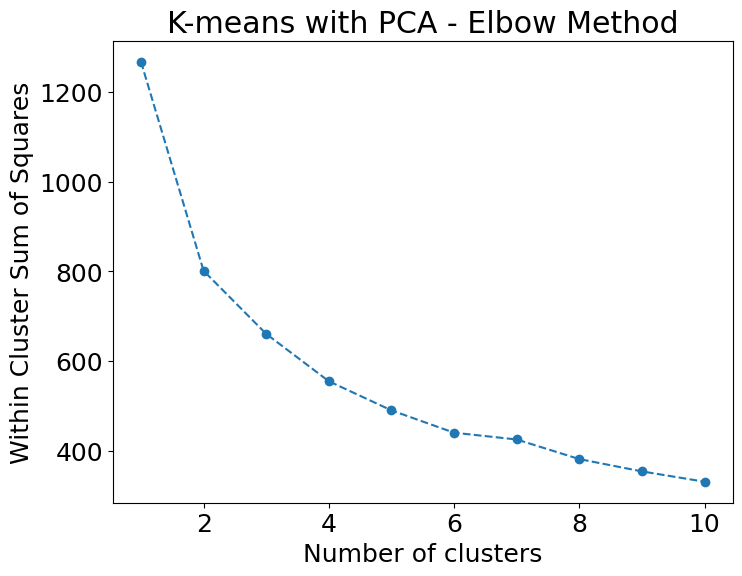

In [145]:
plt.figure(figsize=(8, 6));
plt.plot(range(1, 11), within_cluster_sum_of_squares, marker = 'o', linestyle = '--');
plt.xlabel('Number of clusters');
plt.ylabel('Within Cluster Sum of Squares');
plt.title('K-means with PCA - Elbow Method');
plt.show();

In [146]:
NUM_CLUSTERS = 3

kmeans_pca = KMeans(n_clusters = NUM_CLUSTERS, init = 'k-means++', random_state = 42)
kmeans_pca.fit(X_features_pca)


KMeans(n_clusters=3, random_state=42)

In [147]:
dairy_ag_df_PCA_kmeans = pd.concat([dairy_ag_df_imputed.reset_index(drop=True), pd.DataFrame(X_features_pca)], axis=1)
dairy_ag_df_PCA_kmeans.columns.values[-NUM_COMPONENTS_TO_KEEP:] = ['Component_' + str(i) for i in range(NUM_COMPONENTS_TO_KEEP)] # Add the PCA components to the dataframe
dairy_ag_df_PCA_kmeans['Predicated_Cluster'] = kmeans_pca.labels_

In [148]:
dairy_ag_df_PCA_kmeans.head()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

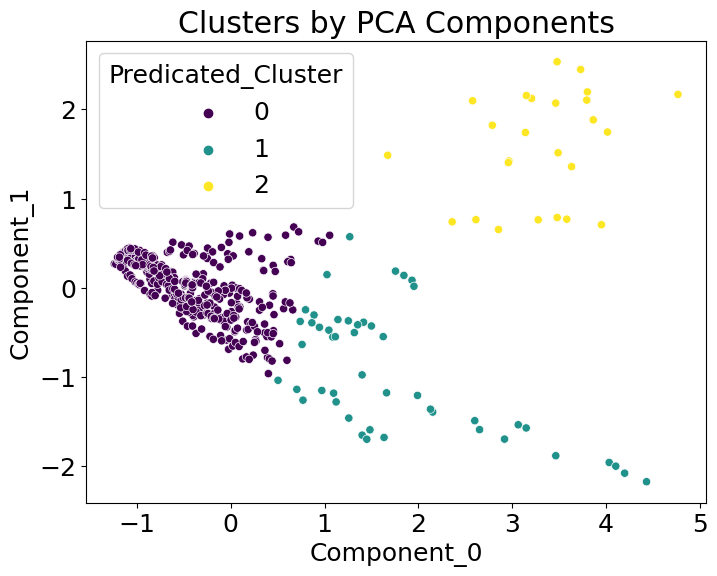

In [149]:
x_axis = dairy_ag_df_PCA_kmeans['Component_0']
y_axis = dairy_ag_df_PCA_kmeans['Component_1']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dairy_ag_df_PCA_kmeans, x=x_axis, y=y_axis, hue=dairy_ag_df_PCA_kmeans['Predicated_Cluster'], palette='viridis')
plt.title('Clusters by PCA Components')
plt.show();

In [150]:
@interact
def show_clusters(cluster=list(range(0, NUM_CLUSTERS)), year=dairy_ag_df_PCA_kmeans['Year'].unique()):
    return dairy_ag_df_PCA_kmeans[(dairy_ag_df_PCA_kmeans['Predicated_Cluster'] == cluster) & (dairy_ag_df_PCA_kmeans.Year == year)][['Member State', "Component_0", "Component_1", "Component_2"]].drop_duplicates().reset_index(drop=True)

interactive(children=(Dropdown(description='cluster', options=(0, 1, 2), value=0), Dropdown(description='year'…

In [151]:
import plotly.express as px
from textwrap import wrap

named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [152]:
dairy_ag_df_PCA_kmeans.columns.tolist()

['Year',
 'Member State',
 "(SE005) Economic size (€'000)",
 '(SE010) Total labour input (AWU)',
 '(SE011) Labour input (hrs)',
 '(SE015) Unpaid labour input (AWU)',
 '(SE016) Unpaid labour input (hrs)',
 '(SE020) Paid labour input (AWU)',
 '(SE021) Paid labour Input (hrs)',
 '(SE025) Total Utilised Agricultural Area (ha)',
 '(SE026) Arable land (ha)',
 '(SE027) Permanent crops (ha)',
 '(SE028) Permanent grassland (ha)',
 '(SE030) Rented UAA (ha)',
 '(SE073) Set aside (ha)',
 '(SE074) Total agricultural area out of production (ha)',
 '(SE080) Total livestock units (LU)',
 '(SE085) Dairy cows (LU)',
 '(SE086) Cattle dairy cows (LU)',
 '(SE087) Buffalo dairy cows (LU)',
 '(SE120) Stocking density (LU/ha)',
 '(SE125) Milk yield (kg/cow)',
 '(SE126) Milk yield cattle dairy cows (kg/cow)',
 '(SE127) Milk yield buffalo dairy cows (kg/cow)',
 '(SE131) Total output (€/farm)',
 '(SE132) Total output / Total input (ratio)',
 '(SE206) Total output livestock & livestock products (€/farm)',
 '(SE20

In [153]:
#https://community.plotly.com/t/traces-from-previous-frames-in-animated-scatterplot/36310

In [155]:
# This needs to be done since our clusters are numbers, and we want to use them as strings for Choropleth graph. 
# Providing numbers keeps resulting in Plotly using continuous scale instead of discrete one.
dairy_ag_df_PCA_kmeans['Predicated_Cluster_STR'] = dairy_ag_df_PCA_kmeans.Predicated_Cluster.astype(str)

color_dictionary = dict(
    zip(
        dairy_ag_df_PCA_kmeans['Predicated_Cluster_STR'].unique().tolist(), 
        px.colors.carto.Temps[:NUM_CLUSTERS:3]
        )
)


#### Kmeans GridSearch & Silhouette Score

In [157]:
clustering = KMeans()
param_grid = {
    "n_clusters": range(2, 11),
}

def scorer(estimator, X, y=None):
    y_pred = estimator.fit_predict(X)
    return silhouette_score(X, y_pred)


grid = GridSearchCV(clustering, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(X_features_pca)
pd.DataFrame(grid.cv_results_)

GridSearchCV(cv=5, estimator=KMeans(), param_grid={'n_clusters': range(2, 11)},
             scoring=<function scorer at 0x0000029761B1A2A0>)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002553,0.002197,0.004422,0.005943,2,{'n_clusters': 2},0.701842,0.706772,0.689240,0.587009,0.528890,0.642751,0.071865,1
1,0.003111,0.000282,0.002636,0.000864,3,{'n_clusters': 3},0.336463,0.634353,0.308106,0.299129,0.329412,0.381493,0.127159,2
2,0.001800,0.001600,0.002964,0.002903,4,{'n_clusters': 4},0.263817,0.262533,0.307953,0.364852,0.476059,0.335043,0.079798,7
3,0.000303,0.000605,0.006259,0.007670,5,{'n_clusters': 5},0.273906,0.311306,0.256052,0.359901,0.392542,0.318741,0.051257,9
4,0.001144,0.001566,0.005905,0.006503,6,{'n_clusters': 6},0.292118,0.331633,0.308637,0.291264,0.424791,0.329688,0.049758,8
5,0.006529,0.007999,0.003062,0.005809,7,{'n_clusters': 7},0.270093,0.356431,0.289840,0.331138,0.477731,0.345047,0.072930,6
6,0.006617,0.008105,0.003375,0.006749,8,{'n_clusters': 8},0.334879,0.385264,0.351851,0.362435,0.472954,0.381476,0.048567,3
7,0.003117,0.006234,0.003565,0.006798,9,{'n_clusters': 9},0.286241,0.320661,0.331248,0.348548,0.521708,0.361681,0.082560,5
8,0.003136,0.005941,0.003531,0.006138,10,{'n_clusters': 10},0.314178,0.377621,0.399212,0.403528,0.393509,0.377610,0.032908,4


## Agglomerathive Clustering 

Dendogram is a tree-like diagram that records the sequence of merges or splits. To get the number of clusters for hierarchical clustering we use the concept of dendogram.

<Figure size 800x800 with 0 Axes>

Text(0.5, 1.0, 'Dendrogram For Proposed Cluster Similarties')

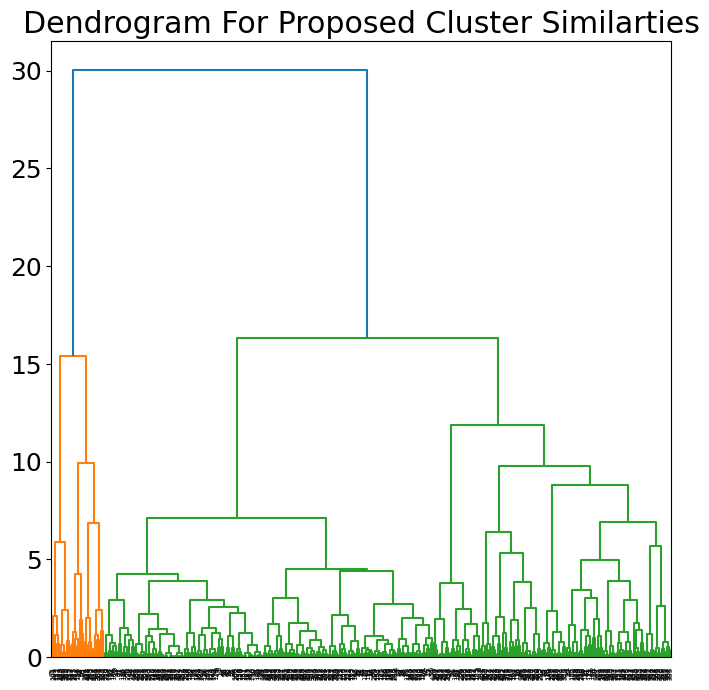

In [226]:
plt.figure(figsize =(8, 8)) 
plt.title('Dendrogram For Proposed Cluster Similarties') 
Dendrogram = shc.dendrogram((shc.linkage(X_features_pca, method ='ward'))) 

In [159]:
agglomerative = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward')
labels = agglomerative.fit_predict(X_features_pca)

dairy_ag_df_PCA_Agglomerative = dairy_ag_df_PCA_kmeans.copy()
dairy_ag_df_PCA_Agglomerative['Predicated_Cluster'] = labels
dairy_ag_df_PCA_Agglomerative['Predicated_Cluster_STR'] = dairy_ag_df_PCA_Agglomerative.Predicated_Cluster.astype(str)

In [160]:
dairy_ag_df_PCA_Agglomerative

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE332) Veterinary expenses (

In [230]:
dairy_ag_df.to_csv('data/dairy_ag_df.csv', index=False)

## Dashboard

#### Dashboard Component 1: Pie Chart for Land Use

In [231]:
dairy_ag_df = pd.read_csv('data/dairy_ag_df.csv')

In [232]:
# Create a melted dataframe which will be used in our pie charts
land_use_columns = ['(SE028) Permanent grassland (ha)', '(SE026) Arable land (ha)', '(SE027) Permanent crops (ha)']

pie_chart_data_all = dairy_ag_df[['Year', 'Member State'] + land_use_columns]
pie_chart_data_all_melted = pie_chart_data_all.melt(id_vars=['Year', 'Member State'], var_name='Land Use', value_name='Area (ha)')
pie_chart_data_all_melted

,Year,Member State,Land Use,Area (ha)
0,2004,Belgium,(SE028) Permanent grassland (ha),23.99
1,2004,Czechia,(SE028) Permanent grassland (ha),113.32
2,2004,Denmark,(SE028) Permanent grassland (ha),9.07
3,2004,Germany,(SE028) Permanent grassland (ha),29.53
4,2004,Estonia,(SE028) Permanent grassland (ha),61.43
...,...,...,...,...
1408,2021,Romania,(SE027) Permanent crops (ha),0.03
1409,2021,Slovenia,(SE027) Permanent crops (ha),0.13
1410,2021,Slovakia,(SE027) Permanent crops (ha),0.11
1411,2021,Finland,(SE027) Permanent crops (ha),0.00


In [233]:
# Assuming dairy_ag_df is a pandas DataFrame and 'Year' is the column with the years
min_year = dairy_ag_df['Year'].min()
max_year = dairy_ag_df['Year'].max()

# Create a DIV that will be used in the Dash App Layout. This is DIV for Member State Comparison (4 member states at a time) based on Land Use
member_state_comparison_div = (
        html.Div([
        # Header for the app
        html.H4('Member State Comparison'),

        # Dropdown for selecting the column to be used for the names
        html.Div([
            html.Div([
                dcc.Dropdown(id='country1',
                    options=dairy_ag_df['Member State'].unique(),
                    value='Ireland', clearable=False
                ),
            ], style={'width': '25%'}),
            html.Div([
                dcc.Dropdown(id='country2',
                    options=dairy_ag_df['Member State'].unique(),
                    value='Denmark', clearable=False
                ),
            ], style={'width': '25%'}),
            html.Div([
                dcc.Dropdown(id='country3',
                    options=dairy_ag_df['Member State'].unique(),
                    value='Lithuania', clearable=False
                ),
            ], style={'width': '25%'}),
            html.Div([
                dcc.Dropdown(id='country4',
                    options=dairy_ag_df['Member State'].unique(),
                    value='Latvia', clearable=False
                ),
            ], style={'width': '25%'}),
        ], style={'display': 'flex', 'flex-direction': 'row'}),

        dcc.Graph(id="pie-graph"),
    ])
)

#### Dashboard Component 2: Geoplot for comparison of different metrics

In [163]:
# geo_d = dairy_ag_df[['Year', 'Member State', 'national_milk_production_tonnes']]
# country_codes = pd.read_csv('data/country_codes.tsv', sep='\t')
# geo_d = geo_d.merge(country_codes, left_on='Member State', right_on='Country', how='left')
# geo_d.rename(columns={'Alpha-3 code': 'country_code'}, inplace=True)
# geo_d

# This is a DIV for Geo Comparison based on the selected column
per_column_geo_div = (
        html.Div([
        # Header for the app
        html.H4('Member State Comparison'),

        # Dropdown for selecting the column to be used for the names
        html.Div([
            dcc.Dropdown(id='column',
                options=dairy_ag_df.columns.tolist(),
                value='national_milk_production_tonnes', 
                clearable=False
            ),
        ], style={'width': '50%'}),

        dcc.Graph(id="geo-graph"),
    ], style={'width': '49%', 'display': 'inline-block'})
)

#### Dashboard Component 3: ML Clustering Result Visualisation

In [238]:
# This is a DIV for ML Resultsfrom PCA & KMeans
ml_results_div = html.Div([
        # Header for the app
        html.H4('Proposed Clustering results for the selected year based on ML model'),
        dcc.Graph(id="ml-clustering-graph"),
    ], style={'width': '49%', 'display': 'inline-block'})

### Dashboard Component 4: Different ML Algorithms Showing Cluster Convergence

In [235]:
ml_both_algorithms_results_div = html.Div([
        # Header for the app
        html.H4('ML Results Indicate Gradual Convergence of Member State Dairy Industries'),
        html.P('The 2 graphs below show the clustering results of the KMeans and Agglomerative algorithms. Member states are colored according to the cluster they were assigned to by each model.'),
        html.Div([
            html.H5('KMeans Clustering'),
            dcc.Graph(id="ml-clustering-kmeans-graph"),
        ], style={'width': '49%', 'display': 'inline-block'}),
        html.Div([
            html.H5('Agglomerative Clustering'),
            dcc.Graph(id="ml-clustering-agglom-graph"),
        ], style={'width': '49%', 'display': 'inline-block'}),
    ])

### Dashboard Component 5: Topic Modelling

In [236]:
modelBert = BERTopic.load("trained_models/bert_topic")
topics_over_timeBERT_df = pd.read_csv('trained_models/bert_topic_over_time')
TOPIC_LOADED_IN_FIGURE = modelBert.visualize_topics_over_time(topics_over_timeBERT_df)

# This is a DIV for ML Resultsfrom PCA & KMeans
topic_div = html.Div([
        # Header for the app
        html.H4('Topic Modelling Based On Reddit Posts'),
        dcc.Graph(id="topic-graph"),
    ], style={'width': '99%', 'display': 'inline-block'})

In [239]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px


app = Dash(__name__)

app.layout = html.Div([

    # Dashboard Component One - Member State Comparison
    member_state_comparison_div,

    # Slider for selecting the year. ONE year will be selected and results for just that year will be shown. 
    # The slider will be COMMON FOR ALL of the graphs to ensure the User can navigate through the years and see the changes to all the graphs
    html.H3('Select Year To Compare Member States'),
    html.Div([
        dcc.Slider(
            id='year-slider',
            min=min_year,
            max=max_year,
            value=min_year,
            step=1,
            marks={year: str(year) for year in range(min_year, max_year+1)},
            included=False, # To only show ONE value and not the whole slider from start to finish
        )
    ], style={'padding-top': '5px', 'padding-bottom': '5px '}),

    # Dashboard Component Two - Geo Map Animated
    per_column_geo_div,

    # Dashboard Component Three - ML Results
    ml_results_div,

    ml_both_algorithms_results_div,

    topic_div,

], style={'backgroundColor': 'white', 'padding-top': '3px', 'padding-left': '2px', 'padding-right': '1px', 'padding-bottom': '3px'})


@app.callback( # Watching for changes in the dropdowns
    Output("pie-graph", "figure"), 
    Input("country1", "value"), 
    Input("country2", "value"),
    Input("country3", "value"),
    Input("country4", "value"), 
    Input("year-slider", "value") # Watching for changes in the slider
    )
# THIS FUNCTION WILL BE CALLED WHENEVER THE DROPDOWNS OR SLIDER CHANGES 
def generate_chart(country1, country2, country3, country4, year_slider): # Function to generate the chart when the changes are made to the inputs, hemce duplicating the input values in the function signature
    d = pie_chart_data_all_melted[(pie_chart_data_all_melted['Member State'].isin([country1, country2, country3, country4])) & (pie_chart_data_all_melted['Year'] == year_slider)]
    
    fig = px.pie(d, values='Area (ha)', names='Land Use', hole=.3, facet_col='Member State')
    fig.update_traces(textposition='inside', textinfo='percent')

    return fig


@app.callback( # Watching for changes in the dropdowns
    Output("geo-graph", "figure"), 
    Input("column", "value"), 
    Input("year-slider", "value") # Watching for changes in the slider
    )
# THIS FUNCTION WILL BE CALLED WHENEVER THE DROPDOWN FOR COLUMN CHANGES
def generate_geo_map(column, year): # Function to generate the chart when the changes are made to the inputs, hemce duplicating the input values in the function signature
    fig = px.choropleth(dairy_ag_df[dairy_ag_df.Year == year],
                        locations="country_code", 
                        color=column, 
                        hover_name="Member State", # column to display in hover information
                        scope='europe', # set the scope to europe
                        color_continuous_scale=px.colors.sequential.Mint,
                        width=800,
                        height=800,
                        )

    # This is to ensure the scale is set for the whole animation
    fig.update_layout(
        coloraxis=dict(cmin=dairy_ag_df[column].min(), cmax=dairy_ag_df[column].max()),
        margin=dict(l=10, r=10, t=10, b=10),  dragmode=False
    )
    fig.update_coloraxes(showscale=False)

    return fig

@app.callback( # Watching for changes in the dropdowns
    Output("ml-clustering-graph", "figure"), 
    Input("year-slider", "value") # Watching for changes in the slider
    )
def visualise_ml_results(year):
    fig = px.choropleth(dairy_ag_df_PCA_kmeans[dairy_ag_df_PCA_kmeans.Year == year],
                    locations="country_code", 
                    color='Predicated_Cluster_STR', 
                    hover_name="Member State", # column to display in hover information
                    scope='europe', # set the scope to europe
                    color_discrete_map=color_dictionary,
                    # color_continuous_scale=px.colors.carto.Temps, # set the color scale
                    width=800,
                    height=800,
                    )
    fig.update_layout(
        margin=dict(l=10, r=10, t=10, b=10), dragmode=False, showlegend=False
    )
    fig.update_coloraxes(showscale=False)

    return fig

@app.callback( # Watching for changes in the dropdowns
        [Output("ml-clustering-kmeans-graph", "figure"), 
         Output("ml-clustering-agglom-graph", "figure")], 
    Input("year-slider", "value") # Watching for changes in the slider
    )
def visualise_convergence_results(custom_div):
    NUM_CLUSTERS = 3

    dairy_ag_df_PCA_kmeans = pd.read_csv('trained_models/dairy_ag_df_PCA_kmeans_results.csv')
    dairy_ag_df_PCA_kmeans['Predicated_Cluster_STR'] = dairy_ag_df_PCA_kmeans.Predicated_Cluster.astype(str)

    color_dictionary = dict(
        zip(
            dairy_ag_df_PCA_kmeans['Predicated_Cluster_STR'].unique().tolist(), 
            px.colors.carto.Temps[:NUM_CLUSTERS:3]
            )
    )

    figKMeans = px.choropleth(dairy_ag_df_PCA_kmeans,
                    locations="country_code", 
                    color='Predicated_Cluster_STR', 
                    hover_name="Member State", # column to display in hover information
                    scope='europe', # set the scope to europe
                    color_discrete_map=color_dictionary,
                    animation_frame="Year",
                    # color_continuous_scale=px.colors.carto.Temps, # set the color scale
                    width=800,
                    height=800,
                    )
    figKMeans.update_layout(
        margin=dict(l=10, r=10, t=10, b=10), showlegend=False
    )
    figKMeans.update_coloraxes(showscale=False)


    dairy_ag_df_PCA_Agglomerative = pd.read_csv('trained_models/dairy_ag_df_PCA_Agglomerative_results.csv')
    dairy_ag_df_PCA_Agglomerative['Predicated_Cluster_STR'] = dairy_ag_df_PCA_Agglomerative.Predicated_Cluster.astype(str)

    color_dictionary = dict(
        zip(
            dairy_ag_df_PCA_kmeans['Predicated_Cluster_STR'].unique().tolist(), 
            px.colors.carto.Temps[:NUM_CLUSTERS:3]
            )
    )

    figAggr = px.choropleth(dairy_ag_df_PCA_Agglomerative,
                    locations="country_code", 
                    color='Predicated_Cluster_STR', 
                    hover_name="Member State", # column to display in hover information
                    scope='europe', # set the scope to europe
                    color_discrete_map=color_dictionary,
                    animation_frame="Year",
                    # color_continuous_scale=px.colors.carto.Temps, # set the color scale
                    width=800,
                    height=800,
                    )
    figAggr.update_layout(
        margin=dict(l=10, r=10, t=10, b=10), showlegend=False
    )
    figAggr.update_coloraxes(showscale=False)


    return figKMeans, figAggr


@app.callback( # Watching for changes in the dropdowns
    Output("topic-graph", "figure"), 
    Input("year-slider", "value") # Watching for changes in the slider
    )
def visualise_topics(year):
    return TOPIC_LOADED_IN_FIGURE

app.run_server(debug=True, port=8072)

# Dairy Sentiment Analysis

In [168]:
from os import getenv, environ
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime as dt
import praw

from praw.models import MoreComments
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import requests
import datetime
import time

from requests.adapters import HTTPAdapter




In [169]:
load_dotenv()

APP_NAME = getenv("APP_NAME")
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
REDDIT_NAME = getenv("REDDIT_NAME")
REDIRECT_URL = "http://localhost:8080"

False

#### Use the Reddit API without any wrappers to performle search on multi-word query. This functionality does not seem to give expected results when using PRAW

##### Step 1: Authenticate

In [170]:
# # Gather the data from local environment variables
# client_auth = requests.auth.HTTPBasicAuth(APP_ID, APP_SECRET)
# post_data = {"grant_type": "client_credentials", 
#              "username": APP_ID, 
#              "password": APP_SECRET, 
#              "redirect_uri": REDIRECT_URL}
# headers = {'User-Agent': f'MacOS:{APP_NAME}:v1.0 (by /u/{REDDIT_NAME})'}

# # Request the access token
# # Token is valid for 1 hour, needs to be refreshed after that
# response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
# access_token = response.json()['access_token']
# access_token

##### Step 2: Create a function to get posts based on a query serach / multi-term search

In [171]:
# def url_override(post):
#     if 'url_overridden_by_dest' in post:
#         return post['url_overridden_by_dest']
#     return ''

# # Get RAW Response Data from Reddit and det parsed_posts array intp which the data will be stored
# def parse_response_data(query_used, res, parsed_posts):
#     response_data = res.json()['data']['children']
#     for post in response_data:
#         print(post['data']['title'])
#         try:
#             parsed_posts.append([
#                 query_used,
#                 post['data']['id'],
#                 post['data']['title'],
#                 post['data']['subreddit'],
#                 post['data']['num_comments'],
#                 post['data']['upvote_ratio'],
#                 post['data']['selftext'],
#                 datetime.datetime.fromtimestamp(post['data']['created_utc']).date(),
#                 url_override(post['data']),
#             ])
#         except Exception as e:
#             print(e)

In [172]:
# https://stackoverflow.com/questions/51793254/why-does-python-requests-return-the-same-data-when-issuing-post-in-a-loop-even-a

##### Step 3: Get Posts from Reddit
Traverse a list of subreddits and apply a list of different queries

In [174]:
# ### John being stupid, Expanded subreddits and mor restrictive queries to try and scrape more relevant topics.

# headers = {'Authorization': f"bearer {access_token}",
#            'User-Agent': f'windows:{APP_NAME}:v1.0 (by /u/{REDDIT_NAME})',
#            'Cache-Control': 'no-cache',
#            'Connection': 'close'}

# SUBREDDITS = ["Milk","farming", "dairyfarming", "Farmers", "science", "nutrition", "europeanparliament", "europe", "europeanunion", "eu", "ireland", "Scotland", "newzealand", "usa"]

# COUNTRIES = ['Ireland', 'Scotland', 'New Zealand', 'USA']
# COUNTRY_QUERIES = [
#            '{0} AND dairy AND common agricultural policy', 
#            '{0} AND dairy AND quota', 
#            '{0} AND dairy AND EU', 
#            '{0} AND dairy AND subsidies', 
#            '{0} AND dairy AND yield', 
#            '{0} AND milk AND price', 
#            '{0} AND dairy AND quality', 
#            '{0} AND dairy AND fertiliser', 
#            '{0} AND dairy AND grass', 
#            '{0} AND dairy AND farmers']

# QUERIES = []

# for country in COUNTRIES:    
#     for query in COUNTRY_QUERIES:
#         QUERIES.append(query.format(country))


# GENERAL_QUERIES = ['dairy AND common agricultural policy', 
#            'dairy AND quota', 
#            'dairy AND EU', 
#            'dairy AND subsidies', 
#            'dairy AND yield', 
#            'milk AND price', 
#            'dairy AND quality', 
#            'dairy AND fertiliser', 
#            'dairy AND grass', 
#            'dairy AND farmers']

# QUERIES.extend(GENERAL_QUERIES)

# LIMIT=100

# print(QUERIES)
# print('Will run the following number of options: ', len(SUBREDDITS) * len(QUERIES))

# parsed_reddit_posts = []

# for subreddit in SUBREDDITS:
#     for query in QUERIES:
#         print('QUERYING: ', 'subreddit: ', subreddit, ' query: ', query)
#         print('--------------------------------')

#         #Call the Reddit API and get the response
#         with requests.Session() as s: 
#             url = f"https://oauth.reddit.com/r/{subreddit}/search/?q={query}&limit={LIMIT}&sort=relevance&t=all&type=link&restrict_sr=true"
#             print('SEARCH URL: ', url)

#             h = HTTPAdapter(max_retries=2) # Do two retries due to network load / connection instability 
#             s.mount('http://', h)
#             res = s.get(url, headers=headers)

#             # Call out utility function which will only extract the fields we want from the response &
#             # store them in the parsed_reddit_posts array
#             if res.status_code == 200:
#                 parse_response_data(query, res, parsed_reddit_posts)
#             else:
#                 print('Request FAILED: ', res.status_code, res.reason)



In [242]:
# parsed_reddit_posts_df = pd.DataFrame(parsed_reddit_posts, columns=['query_used', 'id', 'title', 'subreddit', 'num_comments', 'upvote_ratio', 'selftext', 'created_utc', 'url_overridden_by_dest'])
# parsed_reddit_posts_df.shape

In [201]:
# @interact
# def filter_posts_df(query=QUERIES, subreddit=SUBREDDITS, upvote_ratio=['>= 0.5', '< 0.5']):
#     q_s = parsed_reddit_posts_df[(parsed_reddit_posts_df.query_used == query)]
#     if upvote_ratio == '>= 0.5':
#         return q_s[q_s.upvote_ratio >= 0.5]
#     else:
#         return q_s[q_s.upvote_ratio < 0.5]

In [243]:
# parsed_reddit_posts_df.to_csv('reddit/crawled_posts.csv', index=False)

##### Step 4: Use PRAW to get **comments** for the posts collected above

In [178]:
import time
from random import randrange

In [184]:
# reddit = praw.Reddit(
#     client_id = APP_ID,
#     client_secret = APP_SECRET,
#     user_agent = f"{APP_NAME} u/{REDDIT_NAME}"
# )
# print(reddit.read_only)

In [185]:
# comments = []
# comments_pd_batch_1 = pd.read_csv('reddit/crawled_comments.csv')
# comments_pd_batch_1.post_id.unique().tolist()

In [186]:
# def get_all_comments(comment, level, post_id, post_title):
#     try:
#         comments.append([
#             post_id,
#             post_title,
#             level,
#             comment.body,
#             comment.likes,
#             comment.score,
#             comment.subreddit,
#         ])
#     except Exception as e:
#         print(e)

#     try:
#         if comment.replies:
#             for reply in comment.replies:
#                 get_all_comments(reply, level + 1, post_id, post_title)
#     except Exception as e:
#         print(e)

# # Generate list of gathered post IDs for collected comments. This is to avoid re-gathering comments for the same post
# gathered_post_ids = comments_pd_batch_1.post_id.unique().tolist()

# for count, post_id in enumerate(parsed_reddit_posts_df.id.tolist()):
#     if post_id in gathered_post_ids:
#         print('Post ID ', post_id, 'already gathered comments for, skipping...')
#         continue
    
#     # Sleep for a random amount of time between 1 and 5 minutes. To avoid being throttled by Reddit API. 
#     if count % 200 == 0:
#         print('SLEEPING', randrange(1, 6, 1) * 60)
#         time.sleep(randrange(1, 6, 1) * 60)
    
#     print('Gathering comments for post ID: ', post_id)
#     submission = reddit.submission(post_id)
#     print('Post ID ', submission.id, 'contains ', submission.num_comments, ' comments') # Will be used to validate the resulting dataframes and identify if some comments have been missed

#     # To filter out posts with less than 10 comments.
#     if submission.num_comments >= 10:
#         print('Post has at least 10 comments, proceeding to gathering comments...')
#         for comment in submission.comments:        
#             get_all_comments(comment, level=0, post_id=submission.id, post_title=submission.title)


In [187]:
# comments_pd = pd.DataFrame(comments, columns=[
#         'post_id',
#         'post_title',
#         'comment_level',
#         'comment_body',
#         'comment_likes',
#         'comment_score',
#         'comment_subreddit',
# ])
# comments_pd.to_csv(f"reddit/crawled_comments.csv", mode='a', index=False)

In [188]:
# comments_pd.shape

### After Running Reddit API: Read In The Datasets

In [189]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [203]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drjcn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\drjcn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\drjcn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [204]:
reddit_posts_df = pd.read_csv('reddit/crawled_posts.csv')
reddit_posts_df.shape

(1766, 9)

In [205]:
reddit_comments_df = pd.read_csv('reddit/crawled_comments.csv')
reddit_comments_df.shape

(86343, 7)

### Vader Sentiment analysis

In [258]:
# Creat some utility functions
characters_to_keep = re.compile("[^a-zA-Z!',-]")
stop_words = set(stopwords.words('english')) 


def clean_up_text(text):
    # Initialize an empty list to store the cleaned words
    cleaned = []
    # Create an instance of WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Loop through each word in the text
    for word in text.split(' '):
        # Remove unwanted characters from the word
        word = characters_to_keep.sub('', word)
        word = word.strip(',')
        # Lemmatize the word to its base form
        word = lemmatizer.lemmatize(word)
        # If the word is not a stop word, add it to the cleaned list
        if len(word) > 3 and word not in stop_words:
            cleaned.append(word)

    # Join the cleaned words back into a string with spaces in between
    return ' '.join(cleaned)

#### Testing the cleanup function

In [261]:
class TestCleanUpText(unittest.TestCase):
    def test_clean_up_text(self):
        self.assertEqual(clean_up_text("This is a test!"), "This test!")
        self.assertEqual(clean_up_text("Another test, with more words."), "Another test word")
        self.assertEqual(clean_up_text("Testing, testing, 1, 2, 3."), "Testing testing")

# Create a TestLoader instance
loader = unittest.TestLoader()
# Load the tests from TestCleanUpText
suite = loader.loadTestsFromModule(TestCleanUpText())
# Create a TextTestRunner instance
runner = unittest.TextTestRunner()
# Run the tests
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

#### Vader on Posts

In [207]:
reddit_posts_df.head()

,query_used,id,title,subreddit,num_comments,upvote_ratio,selftext,created_utc,url_overridden_by_dest
0,USA AND milk AND price,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73,0.90,Whole milk you buy at the store tastes so wate...,2023-08-21,NaN
1,USA AND milk AND price,1cdkoum,why is butter expensive while milk yoghurt che...,Milk,5,0.80,i shop a competitive grocery market in elmhurs...,2024-04-26,NaN
2,USA AND milk AND price,9yeyyl,Global Organic Milk market is expected to reac...,Milk,0,1.00,Publisher: QYResearch\nPublished Date: 2018/11...,2018-11-19,NaN
3,dairy AND subsidies,189y11s,Powdered milk?,Milk,9,0.83,"Ive never seen powder come out of a cow, not e...",2023-12-03,NaN
4,milk AND price,1aygctx,MILK CRIMES: Mess with milk - pay the price. C...,Milk,4,0.96,NaN,2024-02-24,https://i.redd.it/srwp0kgrlekc1.jpeg


In [208]:
reddit_posts_df = reddit_posts_df.fillna('')

# Upvote ratio differs between results from different search quesries on the same post, hence we will take the mean of the upvote ratio for each post
mean_upvote_df = reddit_posts_df.groupby([ 'id', 'subreddit' ])['upvote_ratio'].mean().reset_index()

# Group by since we are having multiple queries for the same post
reddit_posts_df = reddit_posts_df.groupby([ 'id',
                                            'title',
                                            'subreddit',
                                            'num_comments',
                                            'selftext',
                                            'created_utc',
                                            'url_overridden_by_dest'])['query_used'].apply(lambda x: ', '.join(x)).reset_index()

reddit_posts_df.shape
mean_upvote_df.shape

# Merge back the upvote ration, which was omitted while aggregating the queries for each post
reddit_posts_df = reddit_posts_df.merge(mean_upvote_df, on=['id', 'subreddit'], how='left')
reddit_posts_df



(1209, 8)

(1209, 3)

,id,title,subreddit,num_comments,selftext,created_utc,url_overridden_by_dest,query_used,upvote_ratio
0,100q82q,Any dairy farmers in North Carolina?,dairyfarming,8,I'm hoping there is a dairy farmer nearby in N...,2023-01-01,,dairy AND farmers,0.67
1,109w65j,🥛💰There were milk price rises in all EU countr...,europeanunion,0,,2023-01-12,https://twitter.com/EU_Eurostat/status/1613477...,milk AND price,1.00
2,10dtccp,What’s the best ratio of different types of gr...,farming,26,,2023-01-16,,dairy AND grass,1.00
3,10efo0n,Dairy farmers ITW,dairyfarming,2,Hi everyone !\n\nI'm an entrepreneur doing a r...,2023-01-17,,dairy AND farmers,0.81
4,10f6uye,Healthiest non dairy milk substitute,nutrition,31,I’m trying to cut off dairy as I’m breastfeedi...,2023-01-18,,dairy AND grass,0.50
...,...,...,...,...,...,...,...,...,...
1204,zsvtf6,Why don't dairy farmers unionise for higher mi...,dairyfarming,8,I was chatting with a dairyman the other day a...,2022-12-22,,"milk AND price, dairy AND farmers",1.00
1205,zuu908,which did you get this year?,newzealand,136,,2022-12-25,https://i.redd.it/0101ju5tb08a1.png,dairy AND EU,0.93
1206,zvbrmt,Are Roses Chocolates really worse? A review of...,newzealand,28,So after reading the thread about Roses chocol...,2022-12-26,,dairy AND quality,0.78
1207,zwxnp5,How do you find a work/life balance dairy farm...,dairyfarming,10,I’m curious how other small dairy farmers (by ...,2022-12-28,,dairy AND farmers,1.00


In [209]:
reddit_posts_df['created_year'] = reddit_posts_df.created_utc.apply(lambda x: x[:4])

In [210]:
reddit_posts_df['title_and_body'] = reddit_posts_df['title'] + ' ' + reddit_posts_df['selftext']

reddit_posts_df.drop(columns=['selftext', 'url_overridden_by_dest'], inplace=True)

reddit_posts_df['cleaned_title'] = reddit_posts_df['title'].apply(clean_up_text) # Apply the function to each row in the dataframe, instead of using for-loop, as this syntax is much more efficient
reddit_posts_df['cleaned_title_and_body'] = reddit_posts_df['title_and_body'].apply(clean_up_text) # Apply the function to each row in the dataframe, instead of using for-loop, as this syntax is much more efficient
reddit_posts_df.head()

,id,title,subreddit,num_comments,created_utc,query_used,upvote_ratio,created_year,title_and_body,cleaned_title,cleaned_title_and_body
0,100q82q,Any dairy farmers in North Carolina?,dairyfarming,8,2023-01-01,dairy AND farmers,0.67,2023,Any dairy farmers in North Carolina? I'm hopin...,dairy farmer North Carolina,dairy farmer North Carolina hoping dairy farme...
1,109w65j,🥛💰There were milk price rises in all EU countr...,europeanunion,0,2023-01-12,milk AND price,1.00,2023,🥛💰There were milk price rises in all EU countr...,There milk price rise country ranging relative...,There milk price rise country ranging relative...
2,10dtccp,What’s the best ratio of different types of gr...,farming,26,2023-01-16,dairy AND grass,1.00,2023,What’s the best ratio of different types of gr...,Whats best ratio different type grass dairy ca...,Whats best ratio different type grass dairy ca...
3,10efo0n,Dairy farmers ITW,dairyfarming,2,2023-01-17,dairy AND farmers,0.81,2023,Dairy farmers ITW Hi everyone !\n\nI'm an entr...,Dairy farmer,Dairy farmer everyone !I'm entrepreneur resear...
4,10f6uye,Healthiest non dairy milk substitute,nutrition,31,2023-01-18,dairy AND grass,0.50,2023,Healthiest non dairy milk substitute I’m tryin...,Healthiest dairy milk substitute,Healthiest dairy milk substitute trying dairy ...


In [211]:
analyzer = SentimentIntensityAnalyzer()

# Produce sentiment for RAW (unprocessed) comments
sentiment_scores = reddit_posts_df.title_and_body.apply(lambda comment: analyzer.polarity_scores(comment))
#sentiment_scores # Print to see what we got
sentiment_scores_df = pd.DataFrame(list(sentiment_scores))[['compound']]
sentiment_scores_df.rename(columns={'compound': 'vader_raw_post_compound'}, inplace=True)

reddit_posts_df = pd.concat([reddit_posts_df, sentiment_scores_df], axis=1)
reddit_posts_df['vader_raw_post_compound_label'] = pd.cut(reddit_posts_df['vader_raw_post_compound'], bins=[-1, -0.5, -0.2, 0.2, 0.5, 1], labels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])


# Produce sentiment for CLEANED comments
sentiment_scores_cleaned = reddit_posts_df.cleaned_title_and_body.apply(lambda comment: analyzer.polarity_scores(comment))
#sentiment_scores_cleaned # Print to see what we got
sentiment_scores_cleaned_df = pd.DataFrame(list(sentiment_scores_cleaned))[['compound']]
sentiment_scores_cleaned_df.rename(columns={'compound': 'vader_cleaned_post_compound'}, inplace=True)

# Concatinate the sentiment scores with the original dataframe
reddit_posts_df = pd.concat([reddit_posts_df, sentiment_scores_cleaned_df], axis=1)
reddit_posts_df['vader_cleaned_post_compound_label'] = pd.cut(reddit_posts_df['vader_cleaned_post_compound'], bins=[-1, -0.5, -0.2, 0.2, 0.5, 1], labels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])

reddit_posts_df.head(10)

,id,title,subreddit,num_comments,created_utc,query_used,upvote_ratio,created_year,title_and_body,cleaned_title,cleaned_title_and_body,vader_raw_post_compound,vader_raw_post_compound_label,vader_cleaned_post_compound,vader_cleaned_post_compound_label
0,100q82q,Any dairy farmers in North Carolina?,dairyfarming,8,2023-01-01,dairy AND farmers,0.67,2023,Any dairy farmers in North Carolina? I'm hopin...,dairy farmer North Carolina,dairy farmer North Carolina hoping dairy farme...,0.2263,positive,0.4215,positive
1,109w65j,🥛💰There were milk price rises in all EU countr...,europeanunion,0,2023-01-12,milk AND price,1.00,2023,🥛💰There were milk price rises in all EU countr...,There milk price rise country ranging relative...,There milk price rise country ranging relative...,-0.2263,negative,-0.2263,negative
2,10dtccp,What’s the best ratio of different types of gr...,farming,26,2023-01-16,dairy AND grass,1.00,2023,What’s the best ratio of different types of gr...,Whats best ratio different type grass dairy ca...,Whats best ratio different type grass dairy ca...,0.6369,very positive,0.6369,very positive
3,10efo0n,Dairy farmers ITW,dairyfarming,2,2023-01-17,dairy AND farmers,0.81,2023,Dairy farmers ITW Hi everyone !\n\nI'm an entr...,Dairy farmer,Dairy farmer everyone !I'm entrepreneur resear...,0.9057,very positive,0.7634,very positive
4,10f6uye,Healthiest non dairy milk substitute,nutrition,31,2023-01-18,dairy AND grass,0.50,2023,Healthiest non dairy milk substitute I’m tryin...,Healthiest dairy milk substitute,Healthiest dairy milk substitute trying dairy ...,0.8360,very positive,0.8834,very positive
5,10fy5j,Working abroad in Nigeria and looking for meal...,nutrition,22,2012-09-25,dairy AND grass,0.81,2012,Working abroad in Nigeria and looking for meal...,Working abroad Nigeria looking meal replacemen...,Working abroad Nigeria looking meal replacemen...,-0.6948,very negative,-0.7177,very negative
6,10kr756,Food price changes in selected countries from ...,europe,12,2023-01-25,milk AND price,0.94,2023,Food price changes in selected countries from ...,Food price change selected country January Dec...,Food price change selected country January Dec...,0.0000,neutral,0.0000,neutral
7,10m1t87,Where to sell used equipment?,dairyfarming,4,2023-01-26,dairy AND farmers,1.00,2023,"Where to sell used equipment? Hey all, I'm a y...",Where sell used equipment,"Where sell used equipment all, young farmer No...",0.9193,very positive,0.9151,very positive
8,10omjj4,highest quality 3% for best price,Milk,1,2023-01-29,milk AND price,0.75,2023,highest quality 3% for best price What milk br...,highest quality best price,highest quality best price What milk brand (Ca...,0.9388,very positive,0.9349,very positive
9,10qydg8,Can we get a farmer’s perspective on this?,dairyfarming,8,2023-02-01,dairy AND farmers,1.00,2023,Can we get a farmer’s perspective on this?,farmer perspective,farmer perspective,0.0000,neutral,0.0000,neutral


In [212]:
reddit_posts_df.shape

(1209, 15)

#### Vader on Comments

In [213]:
reddit_comments_df.head()

,post_id,post_title,comment_level,comment_body,comment_likes,comment_score,comment_subreddit
0,15xiwvh,If you are a milk lover and haven’t tried raw ...,0,I get fresh farm milk for 40¢ a liter any day ...,NaN,6,Milk
1,15xiwvh,If you are a milk lover and haven’t tried raw ...,1,That’s awesome! I buy from stores that sell lo...,NaN,1,Milk
2,15xiwvh,If you are a milk lover and haven’t tried raw ...,2,Yeah but what country? India?,NaN,1,Milk
3,15xiwvh,If you are a milk lover and haven’t tried raw ...,3,USA,NaN,1,Milk
4,15xiwvh,If you are a milk lover and haven’t tried raw ...,4,I mean the guy buying it for 40 cents a liter.,NaN,1,Milk


In [214]:
reddit_comments_df.drop_duplicates(inplace=True)
reddit_comments_df.shape

(64190, 7)

In [215]:
reddit_comments_df['comment_body'] = reddit_comments_df['comment_body'].astype(str)
reddit_comments_df['cleaned_comment'] = reddit_comments_df['comment_body'].apply(clean_up_text)

In [216]:
analyzer = SentimentIntensityAnalyzer()

# Produce sentiment for RAW (unprocessed) comments
sentiment_scores = reddit_comments_df.comment_body.apply(lambda comment: analyzer.polarity_scores(comment))
sentiment_scores # Print to see what we got
sentiment_scores_df = pd.DataFrame(list(sentiment_scores))[['compound']]
sentiment_scores_df.rename(columns={'compound': 'vader_raw_compound'}, inplace=True)

# Produce sentiment for CLEANED comments
sentiment_scores_cleaned = reddit_comments_df.cleaned_comment.apply(lambda comment: analyzer.polarity_scores(comment))
sentiment_scores_cleaned # Print to see what we got
sentiment_scores_cleaned_df = pd.DataFrame(list(sentiment_scores_cleaned))[['compound']]
sentiment_scores_cleaned_df.rename(columns={'compound': 'vader_cleaned_compound'}, inplace=True)


0        {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...
1        {'neg': 0.0, 'neu': 0.733, 'pos': 0.267, 'comp...
2        {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
3        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                               ...                        
86338    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86339    {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
86340    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86341    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86342    {'neg': 0.373, 'neu': 0.375, 'pos': 0.252, 'co...
Name: comment_body, Length: 64190, dtype: object

0        {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'comp...
1        {'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'comp...
2        {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...
3        {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                               ...                        
86338    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86339    {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...
86340    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86341    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
86342    {'neg': 0.521, 'neu': 0.141, 'pos': 0.338, 'co...
Name: cleaned_comment, Length: 64190, dtype: object

In [217]:
# Concatinate the sentiment scores with the original dataframe
reddit_comments_df = pd.concat([reddit_comments_df, sentiment_scores_df, sentiment_scores_cleaned_df], axis=1)
reddit_comments_df['vader_raw_compound_label'] = pd.cut(reddit_comments_df['vader_raw_compound'], bins=[-1, -0.5, -0.2, 0.2, 0.5, 1], labels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])
reddit_comments_df['vader_cleaned_compound_label'] = pd.cut(reddit_comments_df['vader_cleaned_compound'], bins=[-1, -0.5, -0.2, 0.2, 0.5, 1], labels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])

reddit_comments_df.head()
reddit_comments_df.shape

,post_id,post_title,comment_level,comment_body,comment_likes,comment_score,comment_subreddit,cleaned_comment,vader_raw_compound,vader_cleaned_compound,vader_raw_compound_label,vader_cleaned_compound_label
0,15xiwvh,If you are a milk lover and haven’t tried raw ...,0,I get fresh farm milk for 40¢ a liter any day ...,NaN,6,Milk,fresh farm milk liter want home. Life's good,0.6705,0.6705,very positive,very positive
1,15xiwvh,If you are a milk lover and haven’t tried raw ...,1,That’s awesome! I buy from stores that sell lo...,NaN,1,Milk,Thats awesome! store sell local farm milk cent...,0.7609,0.8016,very positive,very positive
2,15xiwvh,If you are a milk lover and haven’t tried raw ...,2,Yeah but what country? India?,NaN,1,Milk,Yeah country India,0.2406,0.2960,positive,positive
3,15xiwvh,If you are a milk lover and haven’t tried raw ...,3,USA,NaN,1,Milk,,0.0000,0.0000,neutral,neutral
4,15xiwvh,If you are a milk lover and haven’t tried raw ...,4,I mean the guy buying it for 40 cents a liter.,NaN,1,Milk,mean buying cent liter.,0.0000,0.0000,neutral,neutral


(81010, 12)

In [218]:
merged_reddit_df = reddit_posts_df.merge(reddit_comments_df, left_on='id', right_on='post_id', how='right')
merged_reddit_df.head(10)
merged_reddit_df.shape

merged_reddit_df.drop(columns=['comment_likes', 'comment_level', 'comment_subreddit', 'comment_score'], inplace=True)
merged_reddit_df.dropna(subset=['subreddit'], inplace=True)


,id,title,subreddit,num_comments,created_utc,query_used,upvote_ratio,created_year,title_and_body,cleaned_title,cleaned_title_and_body,vader_raw_post_compound,vader_raw_post_compound_label,vader_cleaned_post_compound,vader_cleaned_post_compound_label,post_id,post_title,comment_level,comment_body,comment_likes,comment_score,comment_subreddit,cleaned_comment,vader_raw_compound,vader_cleaned_compound,vader_raw_compound_label,vader_cleaned_compound_label
0,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,0,I get fresh farm milk for 40¢ a liter any day ...,NaN,6,Milk,fresh farm milk liter want home. Life's good,0.6705,0.6705,very positive,very positive
1,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,1,That’s awesome! I buy from stores that sell lo...,NaN,1,Milk,Thats awesome! store sell local farm milk cent...,0.7609,0.8016,very positive,very positive
2,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,2,Yeah but what country? India?,NaN,1,Milk,Yeah country India,0.2406,0.2960,positive,positive
3,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,3,USA,NaN,1,Milk,,0.0000,0.0000,neutral,neutral
4,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,4,I mean the guy buying it for 40 cents a liter.,NaN,1,Milk,mean buying cent liter.,0.0000,0.0000,neutral,neutral
5,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,5,Oh since you replied to my comment and not his...,NaN,2,Milk,since replied comment wont show notification h...,0.3182,0.3182,positive,positive
6,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,1,It does sound nice. What country?,NaN,1,Milk,sound nice. What country,0.4215,0.4215,positive,positive
7,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,2023,If you a

(81010, 27)

In [219]:
import matplotlib.pyplot as plt

c:\Users\drjcn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\drjcn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



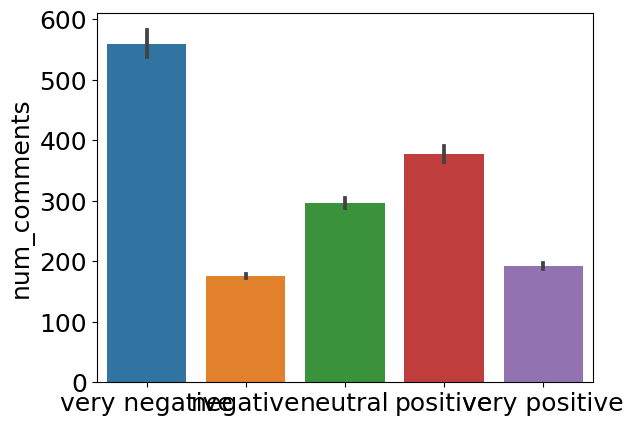

In [227]:
g = sns.barplot(x='vader_raw_post_compound_label', y='num_comments', data=merged_reddit_df)
g.xaxis.label.set_visible(False)
#plt.ylim(0.7, 1)

c:\Users\drjcn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\drjcn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



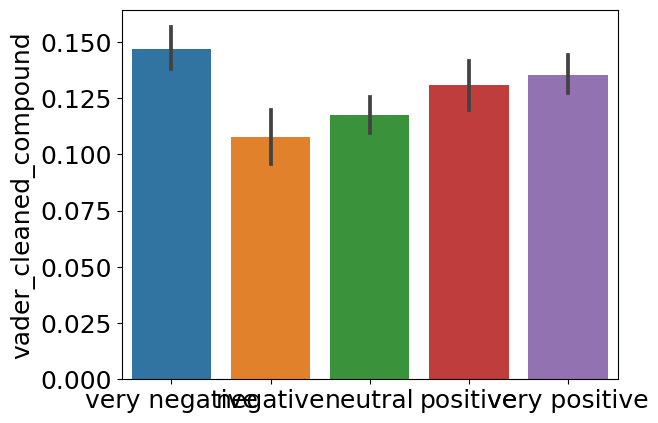

In [229]:
g = sns.barplot(x='vader_raw_post_compound_label', y='vader_cleaned_compound', data=merged_reddit_df)
g.xaxis.label.set_visible(False)


### Topic Modelling for Posts

In [222]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        token = WordNetLemmatizer().lemmatize(token)
        if len(token) > 3 and token not in gensim.parsing.preprocessing.STOPWORDS and 'http' not in token:
            result.append(token)
    return result


def create_LDA_model(inputs_cleaned_processed, no_below=0.5, no_above=0.90, keep_n=100000, num_topics=10, passes=20):
    dictionary = gensim.corpora.Dictionary(inputs_cleaned_processed)

    # Filter out words that occur in at least 50% of the posts.
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)
    # Create a bag-of-words model for each document.
    bow_corpus = [dictionary.doc2bow(doc) for doc in inputs_cleaned_processed]

    model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=passes, workers=2)
    vis = pyLDAvis.gensim.prepare(model, bow_corpus, dictionary)

    return model, vis


#### Topic analysis on post Title & Body

In [223]:
# Apply preprocessing to the 'title_and_body' column and store in a different dataframe
title_and_body_processed = merged_reddit_df['title_and_body'].map(preprocess)

# Create the LDA model
lda_model_title_and_body, vis_title_body = create_LDA_model(title_and_body_processed)

In [224]:
for idx, topic in lda_model_title_and_body.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"butter" + 0.017*"dairy" + 0.010*"farming" + 0.009*"high" + 0.008*"disease" + 0.008*"like" + 0.008*"vogel" + 0.007*"dovedale" + 0.007*"free" + 0.007*"carbon"
Topic: 1 
Words: 0.022*"going" + 0.019*"people" + 0.019*"shit" + 0.015*"life" + 0.012*"need" + 0.010*"transition" + 0.010*"country" + 0.009*"like" + 0.009*"change" + 0.009*"continue"
Topic: 2 
Words: 0.033*"price" + 0.029*"dairy" + 0.021*"milk" + 0.020*"zealand" + 0.015*"meat" + 0.014*"cheese" + 0.011*"farmer" + 0.010*"year" + 0.009*"grass" + 0.009*"good"
Topic: 3 
Words: 0.023*"ireland" + 0.021*"people" + 0.020*"like" + 0.018*"supplement" + 0.012*"year" + 0.012*"grass" + 0.009*"vitamin" + 0.009*"fertiliser" + 0.008*"need" + 0.007*"little"
Topic: 4 
Words: 0.046*"farmer" + 0.030*"dairy" + 0.019*"farming" + 0.017*"news" + 0.015*"water" + 0.012*"farm" + 0.012*"industry" + 0.011*"government" + 0.010*"fonterra" + 0.010*"climate"
Topic: 5 
Words: 0.021*"coffee" + 0.021*"time" + 0.018*"people" + 0.014*"drink" + 0.

In [ ]:
pyLDAvis.display(vis_title_body)

#### Topic analysis on post Title *only*

In [ ]:
title_processed = merged_reddit_df['title'].map(preprocess)

lda_model_title, vis_title = create_LDA_model(title_processed, no_below=0.5, no_above=0.90, keep_n=1000, num_topics=5)

In [ ]:
for idx, topic in lda_model_title.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.081*"price" + 0.074*"zealand" + 0.046*"milk" + 0.023*"food" + 0.020*"think" + 0.019*"coffee" + 0.018*"ireland" + 0.017*"government" + 0.016*"country" + 0.016*"dairy"
Topic: 1 
Words: 0.051*"dairy" + 0.035*"farm" + 0.027*"want" + 0.024*"price" + 0.021*"climate" + 0.021*"fonterra" + 0.020*"say" + 0.018*"grass" + 0.017*"produce" + 0.017*"year"
Topic: 2 
Words: 0.035*"high" + 0.023*"dairy" + 0.021*"quality" + 0.020*"decrease" + 0.019*"cheese" + 0.018*"milk" + 0.017*"block" + 0.016*"possible" + 0.016*"butter" + 0.015*"irish"
Topic: 3 
Words: 0.052*"cost" + 0.040*"water" + 0.033*"ireland" + 0.026*"live" + 0.025*"milk" + 0.025*"biggest" + 0.021*"rise" + 0.021*"house" + 0.019*"price" + 0.017*"know"
Topic: 4 
Words: 0.117*"dairy" + 0.101*"farmers" + 0.041*"farm" + 0.020*"milk" + 0.019*"farmer" + 0.018*"go" + 0.015*"bank" + 0.014*"meat" + 0.014*"staff" + 0.012*"cow"


In [ ]:
pyLDAvis.display(vis_title)

#### Topic analysis on **Very Negative** Comments

In [ ]:
negative_comments_df = merged_reddit_df[merged_reddit_df['vader_cleaned_compound_label'].isin(['very negative', 'negative'])]
negative_comments_df.head()

,id,title,subreddit,num_comments,created_utc,query_used,upvote_ratio,title_and_body,cleaned_title_and_body,vader_raw_post_compound,vader_raw_post_compound_label,vader_cleaned_post_compound,vader_cleaned_post_compound_label,post_id,post_title,comment_body,cleaned_comment,vader_raw_compound,vader_cleaned_compound,vader_raw_compound_label,vader_cleaned_compound_label
19,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,Yeah that’s a lazy argument. You don’t see the...,Yeah thats lazy argument. dont thinking thats ...,-0.3400,-0.7721,negative,very negative
22,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,I find “ultra pasteurized“ often tastes like s...,find ultra pasteurized often taste like scalde...,-0.4767,-0.3182,negative,negative
25,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,Problem is Holstein cows produce milk that has...,Problem Holstein produce milk protein called g...,-0.4497,-0.7003,negative,very negative
34,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,And raw milk will make you sick?,milk make sick,-0.5106,-0.5106,very negative,very negative
35,15xiwvh,If you are a milk lover and haven’t tried raw ...,Milk,73.0,2023-08-21,"USA AND milk AND price, milk AND price",0.9,If you are a milk lover and haven’t tried raw ...,milk lover havent tried milk disservice Whole ...,0.9311,very positive,0.9311,very positive,15xiwvh,If you are a milk lover and haven’t tried raw ...,"It very well can, we didn't start pasteurizing...","well can, start pasteurizing food all. high he...",-0.6490,-0.8910,very negative,very negative


In [ ]:
negative_comments_processed = negative_comments_df['cleaned_comment'].map(preprocess)

lda_model_negative_comments, vis_negative_comments = create_LDA_model(negative_comments_processed, no_below=0.5, no_above=0.90, keep_n=1000, num_topics=5)

for idx, topic in lda_model_negative_comments.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

pyLDAvis.display(vis_negative_comments)

Topic: 0 
Words: 0.060*"milk" + 0.034*"people" + 0.013*"think" + 0.010*"thing" + 0.010*"drink" + 0.009*"know" + 0.009*"like" + 0.008*"point" + 0.008*"study" + 0.007*"say"
Topic: 1 
Words: 0.030*"like" + 0.026*"remove" + 0.022*"delete" + 0.019*"fuck" + 0.019*"time" + 0.016*"taste" + 0.015*"good" + 0.014*"yeah" + 0.014*"coffee" + 0.013*"right"
Topic: 2 
Words: 0.034*"price" + 0.020*"dairy" + 0.020*"farmer" + 0.018*"farm" + 0.015*"produce" + 0.014*"cost" + 0.014*"market" + 0.012*"food" + 0.012*"milk" + 0.012*"production"
Topic: 3 
Words: 0.020*"farm" + 0.014*"like" + 0.013*"work" + 0.012*"year" + 0.012*"think" + 0.011*"live" + 0.011*"people" + 0.010*"know" + 0.010*"go" + 0.010*"want"
Topic: 4 
Words: 0.036*"meat" + 0.031*"food" + 0.020*"cheese" + 0.015*"like" + 0.015*"diet" + 0.013*"eat" + 0.011*"animal" + 0.011*"sugar" + 0.011*"think" + 0.011*"dairy"


#### Attempting Google BERT Based Topic Analysis

In [ ]:
from bertopic import BERTopic

In [ ]:
reddit_posts_df.head()

,id,title,subreddit,num_comments,created_utc,query_used,upvote_ratio,created_year,title_and_body,cleaned_title,cleaned_title_and_body
0,100q82q,Any dairy farmers in North Carolina?,dairyfarming,8,2023-01-01,dairy AND farmers,0.67,2023,Any dairy farmers in North Carolina? I'm hopin...,dairy farmer North Carolina,dairy farmer North Carolina hoping dairy farme...
1,109w65j,🥛💰There were milk price rises in all EU countr...,europeanunion,0,2023-01-12,milk AND price,1.00,2023,🥛💰There were milk price rises in all EU countr...,There milk price rise country ranging relative...,There milk price rise country ranging relative...
2,10dtccp,What’s the best ratio of different types of gr...,farming,26,2023-01-16,dairy AND grass,1.00,2023,What’s the best ratio of different types of gr...,Whats best ratio different type grass dairy ca...,Whats best ratio different type grass dairy ca...
3,10efo0n,Dairy farmers ITW,dairyfarming,2,2023-01-17,dairy AND farmers,0.81,2023,Dairy farmers ITW Hi everyone !\n\nI'm an entr...,Dairy farmer,Dairy farmer everyone !I'm entrepreneur resear...
4,10f6uye,Healthiest non dairy milk substitute,nutrition,31,2023-01-18,dairy AND grass,0.50,2023,Healthiest non dairy milk substitute I’m tryin...,Healthiest dairy milk substitute,Healthiest dairy milk substitute trying dairy ...


In [ ]:
reddit_posts_df_IRELAND = reddit_posts_df[reddit_posts_df.subreddit.isin(['dairyfarming',
                                                                        'europeanunion',
                                                                        'farming',
                                                                        'europe',
                                                                        'Milk',
                                                                        'ireland',
                                                                        'science',
                                                                        'eu',
                                                                        'europeanparliament'])]

In [ ]:
model = BERTopic(nr_topics=10)
topics, probs = model.fit_transform(reddit_posts_df_IRELAND.cleaned_title)

In [ ]:
topics_over_time = model.topics_over_time(reddit_posts_df_IRELAND.cleaned_title, reddit_posts_df_IRELAND.created_year)
model.visualize_topics_over_time(topics_over_time)

In [ ]:
model.save("trained_models/bert_topic", serialization="pickle")
topics_over_time.to_csv('trained_models/bert_topic_over_time')

2024-05-26 12:38:30,930 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
